# eICU Data Joining
---

Reading and joining all parts of the eICU dataset from MIT with the data from over 139k patients collected in the US.

The main goal of this notebook is to prepare a single CSV document that contains all the relevant data to be used when training a machine learning model that predicts mortality, joining tables, filtering useless columns and performing imputation.

## Importing the necessary packages

In [1]:
import dask.dataframe as dd                # Dask to handle big data in dataframes
import pandas as pd                        # Pandas to load the data initially
from dask.distributed import Client        # Dask scheduler
from dask.diagnostics import ProgressBar   # Dask progress bar
import re                                  # re to do regex searches in string data
import os                                  # os handles directory/workspace changes
import numpy as np                         # NumPy to handle numeric and NaN operations
from tqdm import tqdm_notebook             # tqdm allows to track code execution progress
import numbers                             # numbers allows to check if data is numeric
import utils                               # Contains auxiliary functions

In [2]:
# Debugging packages
import pixiedust                           # Debugging in Jupyter Notebook cells

Pixiedust database opened successfully


In [3]:
# Change to parent directory (presumably "Documents")
os.chdir("../../..")

# Path to the CSV dataset files
data_path = 'Documents/Datasets/Thesis/eICU/uncompressed/'
project_path = 'Documents/GitHub/eICU-mortality-prediction/'

In [4]:
# Set up local cluster
client = Client("tcp://127.0.0.1:64615")
client

Client Scheduler: tcp://127.0.0.1:64615 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 8.59 GB


In [5]:
# Upload the utils.py file, so that the Dask cluster has access to relevant auxiliary functions
client.upload_file(f'{project_path}NeuralNetwork.py')
client.upload_file(f'{project_path}utils.py')

In [6]:
client.run(os.getcwd)

{'tcp://127.0.0.1:64622': '/Users/andreferreira',
 'tcp://127.0.0.1:64623': '/Users/andreferreira',
 'tcp://127.0.0.1:64624': '/Users/andreferreira',
 'tcp://127.0.0.1:64628': '/Users/andreferreira'}

## Initialize variables

In [7]:
cat_feat = []                              # List of categorical features
cat_embed_feat = []                        # List of categorical features that will be embedded
cat_embed_feat_enum = dict()               # Dictionary of the enumerations of the categorical features that will be embedded

## Patient data

### Read the data

In [ ]:
patient_df = dd.read_csv(f'{data_path}original/patient.csv')
patient_df.head()

In [ ]:
patient_df = patient_df.repartition(npartitions=30)

In [ ]:
patient_df.npartitions

In [ ]:
len(patient_df)

In [ ]:
patient_df.patientunitstayid.value_counts().compute()

Get an overview of the dataframe through the `describe` method:

In [ ]:
patient_df.describe().compute().transpose()

In [ ]:
patient_df.visualize()

In [ ]:
patient_df.columns

In [ ]:
patient_df.dtypes

### Check for missing values

In [ ]:
utils.dataframe_missing_values(patient_df)

### Remove unneeded features

Besides removing unneeded hospital and time information, I'm also removing the admission diagnosis (`apacheadmissiondx`) as it doesn't follow the same structure as the remaining diagnosis data (which is categorized in increasingly specific categories, separated by "|").

In [ ]:
patient_df = patient_df[['patientunitstayid', 'gender', 'age', 'ethnicity',  'admissionheight',
                         'hospitaldischargeoffset', 'hospitaldischargelocation', 'hospitaldischargestatus',
                         'admissionweight', 'dischargeweight', 'unitdischargeoffset']]
patient_df.head()

### Make the age feature numeric

In the eICU dataset, ages above 89 years old are not specified. Instead, we just receive the indication "> 89". In order to be able to work with the age feature numerically, we'll just replace the "> 89" values with "90", as if the patient is 90 years old. It might not always be the case, but it shouldn't be very different and it probably doesn't affect too much the model's logic.

In [ ]:
patient_df.age.value_counts().head()

In [ ]:
# Replace the "> 89" years old indication with 90 years
patient_df.age = patient_df.age.replace(to_replace='> 89', value=90)

In [ ]:
patient_df.age.value_counts().head()

In [ ]:
# Make the age feature numeric
patient_df.age = patient_df.age.astype(float)

In [ ]:
patient_df.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
patient_df = client.persist(patient_df)

In [ ]:
patient_df.visualize()

### Discretize categorical features

Convert binary categorical features into simple numberings, one hot encode features with a low number of categories (in this case, 5) and enumerate sparse categorical features that will be embedded.

#### Convert binary categorical features into numeric

In [ ]:
patient_df.gender.value_counts().compute()

In [ ]:
patient_df.gender = patient_df.gender.map(lambda x: 1 if x == 'Male' else 0 if x == 'Female' else np.nan)

In [ ]:
patient_df.gender.value_counts().compute()

#### Separate and prepare features for embedding

Identify categorical features that have more than 5 unique categories, which will go through an embedding layer afterwards, and enumerate them.


Update list of categorical features and add those that will need embedding (features with more than 5 unique values):

In [ ]:
new_cat_feat = ['ethnicity']
[cat_feat.append(col) for col in new_cat_feat]

In [ ]:
cat_feat_nunique = [patient_df[feature].nunique().compute() for feature in new_cat_feat]
cat_feat_nunique

In [ ]:
new_cat_embed_feat = []
for i in range(len(new_cat_feat)):
    if cat_feat_nunique[i] > 5:
        # Add feature to the list of those that will be embedded
        cat_embed_feat.append(new_cat_feat[i])
        # Add feature to the list of the new ones (from the current table) that will be embedded
        new_cat_embed_feat.append(new_cat_feat[i])

In [ ]:
patient_df[new_cat_feat].head()

In [ ]:
for i in range(len(new_cat_embed_feat)):
    feature = new_cat_embed_feat[i]
    # Prepare for embedding, i.e. enumerate categories
    patient_df[feature], cat_embed_feat_enum[feature] = utils.enum_categorical_feature(patient_df, feature)

In [ ]:
patient_df[new_cat_feat].head()

In [ ]:
cat_embed_feat_enum

In [ ]:
patient_df[cat_feat].dtypes

In [ ]:
patient_df.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
patient_df = client.persist(patient_df)

In [ ]:
patient_df.visualize()

### Create mortality label

Combine info from discharge location and discharge status. Using the hospital discharge data, instead of the unit, as it has a longer perspective on the patient's status. I then save a feature called "deathOffset", which has a number if the patient is dead on hospital discharge or is NaN if the patient is still alive/unknown (presumed alive if unknown). Based on this, a label can be made later on, when all the tables are combined in a single dataframe, indicating if a patient dies in the following X time, according to how faraway we want to predict.

In [ ]:
patient_df.hospitaldischargestatus.value_counts().compute()

In [ ]:
patient_df.hospitaldischargelocation.value_counts().compute()

In [ ]:
patient_df['deathoffset'] = patient_df.apply(lambda df: df['hospitaldischargeoffset']
                                                        if df['hospitaldischargestatus'] == 'Expired' or
                                                        df['hospitaldischargelocation'] == 'Death' else np.nan, axis=1,
                                                        meta=('x', float))
patient_df.head()

Remove the now unneeded hospital discharge features:

In [ ]:
patient_df = patient_df.drop(['hospitaldischargeoffset', 'hospitaldischargestatus', 'hospitaldischargelocation'], axis=1)
patient_df.head(6)

In [ ]:
patient_df.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
patient_df = client.persist(patient_df)

In [ ]:
patient_df.visualize()

### Create a discharge instance and the timestamp feature

Create the timestamp (`ts`) feature:

In [ ]:
patient_df['ts'] = 0
patient_df.head()

Create a weight feature:

In [ ]:
# Create feature weight and assign the initial weight that the patient has on admission
patient_df['weight'] = patient_df['admissionweight']
patient_df.head()

Duplicate every row, so as to create a discharge event:

In [ ]:
new_df = patient_df.copy()
new_df.head()

Set the `weight` and `ts` features to initially have the value on admission and, on the second timestamp, have the value on discharge:

In [ ]:
new_df.ts = new_df.unitdischargeoffset
new_df.weight = new_df.dischargeweight
new_df.head()

Join the new rows to the remaining dataframe:

In [ ]:
patient_df = patient_df.append(new_df)
patient_df.head()

In [ ]:
patient_df = patient_df.repartition(npartitions=30)

Remove the remaining, now unneeded, weight and timestamp features:

In [ ]:
patient_df = patient_df.drop(['admissionweight', 'dischargeweight', 'unitdischargeoffset'], axis=1)
patient_df.head(6)

Sort by `patientunitstayid` so as to check the data of the each patient together:

In [ ]:
patient_df.compute().sort_values(by='patientunitstayid').head(6)

Sort by `ts` so as to be easier to merge with other dataframes later:

In [ ]:
patient_df = patient_df.set_index('ts')
patient_df.head(6, npartitions=patient_df.npartitions)

In [ ]:
patient_df.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
patient_df = client.persist(patient_df)

In [ ]:
patient_df.visualize()

### Normalize data

Save the dataframe before normalizing:

In [ ]:
patient_df.to_parquet(f'{data_path}cleaned/unnormalized/patient.parquet')

In [ ]:
new_cat_feat

In [ ]:
patient_df.head(npartitions=patient_df.npartitions)

In [ ]:
patient_df_norm = utils.normalize_data(patient_df, embed_columns=new_cat_feat,
                                       id_columns=['patientunitstayid', 'deathoffset'])
patient_df_norm.head(6, npartitions=patient_df.npartitions)

In [ ]:
patient_df_norm.to_parquet(f'{data_path}cleaned/normalized/patient.parquet')

Confirm that everything is ok through the `describe` method:

In [ ]:
patient_df_norm.describe().compute().transpose()

## Vital signs periodic data

### Read the data

In [ ]:
vital_prdc_df = dd.read_csv(f'{data_path}original/vitalPeriodic.csv')
vital_prdc_df.head()

In [ ]:
vital_prdc_df.npartitions

In [ ]:
vital_prdc_df = vital_prdc_df.repartition(npartitions=30)

Get an overview of the dataframe through the `describe` method:

In [ ]:
vital_prdc_df.describe().compute().transpose()

In [ ]:
vital_prdc_df.visualize()

In [ ]:
vital_prdc_df.columns

In [ ]:
vital_prdc_df.dtypes

### Check for missing values

In [ ]:
utils.dataframe_missing_values(patient_df)

### Remove unneeded features

In [ ]:
patient_df = patient_df[['patientunitstayid', 'gender', 'age', 'ethnicity', 'apacheadmissiondx',  'admissionheight',
                         'hospitaldischargeoffset', 'hospitaldischargelocation', 'hospitaldischargestatus',
                         'admissionweight', 'dischargeweight', 'unitdischargeoffset']]
patient_df.head()

### Discretize categorical features

Convert binary categorical features into simple numberings, one hot encode features with a low number of categories (in this case, 5) and enumerate sparse categorical features that will be embedded.

#### Convert binary categorical features into numeric

In [ ]:
patient_df.gender.value_counts().compute()

In [ ]:
patient_df.gender = patient_df.gender.map(lambda x: 1 if x == 'Male' else 0 if x == 'Female' else np.nan)

In [ ]:
patient_df.gender.value_counts().compute()

#### Separate and prepare features for embedding

Identify categorical features that have more than 5 unique categories, which will go through an embedding layer afterwards, and enumerate them.

Update list of categorical features and add those that will need embedding (features with more than 5 unique values):

In [ ]:
new_cat_feat = ['ethnicity', 'apacheadmissiondx']
[cat_feat.append(col) for col in new_cat_feat]

In [ ]:
cat_feat_nunique = [patient_df[feature].nunique().compute() for feature in new_cat_feat]
cat_feat_nunique

In [ ]:
new_cat_embed_feat = []
for i in range(len(new_cat_feat)):
    if cat_feat_nunique[i] > 5:
        # Add feature to the list of those that will be embedded
        cat_embed_feat.append(new_cat_feat[i])
        # Add feature to the list of the new ones (from the current table) that will be embedded
        new_cat_embed_feat.append(new_cat_feat[i])

In [ ]:
patient_df[new_cat_feat].head()

In [ ]:
for i in range(len(new_cat_embed_feat)):
    feature = new_cat_embed_feat[i]
    # Prepare for embedding, i.e. enumerate categories
    patient_df[feature], cat_embed_feat_enum[feature] = utils.enum_categorical_feature(patient_df, feature)

In [ ]:
patient_df[new_cat_feat].head()

In [ ]:
cat_embed_feat_enum

In [ ]:
patient_df[cat_feat].dtypes

In [ ]:
patient_df.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
patient_df = client.persist(patient_df)

In [ ]:
patient_df.visualize()

### Create the timestamp feature and sort

Create the timestamp (`ts`) feature:

In [ ]:
patient_df['ts'] = 0
vital_aprdc_df = vital_aprdc_df.drop('observationoffset', axis=1)
patient_df.head()

In [ ]:
patient_df.patientunitstayid.value_counts().compute()

Remove duplicate rows:

In [ ]:
len(patient_df)

In [ ]:
patient_df = patient_df.drop_duplicates()
patient_df.head()

In [ ]:
len(patient_df)

In [ ]:
patient_df = patient_df.repartition(npartitions=30)

Sort by `ts` so as to be easier to merge with other dataframes later:

In [ ]:
vital_prdc_df = vital_prdc_df.set_index('ts')
vital_prdc_df.head(6)

In [ ]:
patient_df.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
patient_df = client.persist(patient_df)

In [ ]:
patient_df.visualize()

Check for possible multiple rows with the same unit stay ID and timestamp:

In [ ]:
micro_df.reset_index().head()

In [ ]:
micro_df.reset_index().groupby(['patientunitstayid', 'ts']).count().nlargest(columns='culturesite').head()

In [ ]:
micro_df[micro_df.patientunitstayid == 3069495].compute().head(20)

### Join rows that have the same IDs

In [ ]:
micro_df = utils.join_categorical_enum(micro_df, new_cat_embed_feat)
micro_df.head()

In [ ]:
micro_df.dtypes

In [ ]:
micro_df.reset_index().groupby(['patientunitstayid', 'ts']).count().nlargest(columns='culturesite').head()

In [ ]:
micro_df[micro_df.patientunitstayid == 3069495].compute().head(20)

Comparing the output from the two previous cells with what we had before the `join_categorical_enum` method, we can see that all rows with duplicate IDs have been successfully joined.

In [ ]:
micro_df.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
micro_df = client.persist(micro_df)

In [ ]:
micro_df.visualize()

### Normalize data

Save the dataframe before normalizing:

In [ ]:
patient_df.to_parquet(f'{data_path}cleaned/unnormalized/patient.parquet')

In [ ]:
patient_df_norm = utils.normalize_data(patient_df, embed_columns=new_cat_feat,
                                       id_columns=['patientunitstayid', 'ts', 'deathoffset'])
patient_df_norm.head(6)

In [ ]:
patient_df_norm.to_parquet(f'{data_path}cleaned/normalized/patient.parquet')

Confirm that everything is ok through the `describe` method:

In [ ]:
patient_df_norm.describe().compute().transpose()

### Join dataframes

Merge dataframes by the unit stay, `patientunitstayid`, and the timestamp, `ts`, with a tolerence for a difference of up to 30 minutes.

In [ ]:
patient_df = dd.read_parquet(f'{data_path}cleaned/normalized/patient.parquet')
patient_df.head()

In [ ]:
vital_prdc_df = dd.read_parquet(f'{data_path}cleaned/normalized/vitalPeriodic.parquet')
vital_prdc_df.head()

In [ ]:
eICU_df = dd.merge_asof(patient_df, vital_aprdc_df, on='ts', by='patientunitstayid', direction='nearest', tolerance=30)
eICU_df.head()

## Vital signs aperiodic data

### Read the data

In [ ]:
vital_aprdc_df = dd.read_csv(f'{data_path}original/vitalAperiodic.csv')
vital_aprdc_df.head()

In [ ]:
len(vital_aprdc_df)

In [ ]:
vital_aprdc_df.patientunitstayid.nunique().compute()

In [ ]:
vital_aprdc_df.npartitions

In [ ]:
vital_aprdc_df = vital_aprdc_df.repartition(npartitions=30)

Get an overview of the dataframe through the `describe` method:

In [ ]:
vital_aprdc_df.describe().compute().transpose()

In [ ]:
vital_aprdc_df.visualize()

In [ ]:
vital_aprdc_df.columns

In [ ]:
vital_aprdc_df.dtypes

### Check for missing values

In [ ]:
utils.dataframe_missing_values(vital_aprdc_df)

### Remove unneeded features

In [ ]:
vital_aprdc_df = vital_aprdc_df.drop('vitalaperiodicid', axis=1)
vital_aprdc_df.head()

### Create the timestamp feature and sort

Create the timestamp (`ts`) feature:

In [ ]:
vital_aprdc_df['ts'] = vital_aprdc_df['observationoffset']
vital_aprdc_df = vital_aprdc_df.drop('observationoffset', axis=1)
vital_aprdc_df.head()

Remove duplicate rows:

In [ ]:
len(vital_aprdc_df)

In [ ]:
vital_aprdc_df = vital_aprdc_df.drop_duplicates()
vital_aprdc_df.head()

In [ ]:
len(vital_aprdc_df)

In [ ]:
vital_aprdc_df = vital_aprdc_df.repartition(npartitions=30)

Sort by `ts` so as to be easier to merge with other dataframes later:

In [ ]:
vital_aprdc_df = vital_aprdc_df.set_index('ts')
vital_aprdc_df.head(6)

In [ ]:
vital_aprdc_df.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
vital_aprdc_df = client.persist(vital_aprdc_df)

In [ ]:
vital_aprdc_df.visualize()

Check for possible multiple rows with the same unit stay ID and timestamp:

In [ ]:
vital_aprdc_df.reset_index().groupby(['patientunitstayid', 'ts']).count().nlargest(columns='noninvasivemean').head()

In [ ]:
vital_aprdc_df[micro_df.patientunitstayid == 3069495].compute().head(20)

### Join rows that have the same IDs

In [ ]:
micro_df = utils.join_categorical_enum(micro_df, new_cat_embed_feat)
micro_df.head()

In [ ]:
micro_df.dtypes

In [ ]:
micro_df.reset_index().groupby(['patientunitstayid', 'ts']).count().nlargest(columns='culturesite').head()

In [ ]:
micro_df[micro_df.patientunitstayid == 3069495].compute().head(20)

Comparing the output from the two previous cells with what we had before the `join_categorical_enum` method, we can see that all rows with duplicate IDs have been successfully joined.

In [ ]:
micro_df.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
micro_df = client.persist(micro_df)

In [ ]:
micro_df.visualize()

### Normalize data

Save the dataframe before normalizing:

In [ ]:
vital_aprdc_df.to_parquet(f'{data_path}cleaned/unnormalized/vitalAperiodic.parquet')

In [ ]:
vital_aprdc_df_norm = utils.normalize_data(vital_aprdc_df,
                                           id_columns=['patientunitstayid', 'ts'])
vital_aprdc_df_norm.head(6)

In [ ]:
vital_aprdc_df_norm.to_parquet(f'{data_path}cleaned/normalized/vitalAperiodic.parquet')

Confirm that everything is ok through the `describe` method:

In [ ]:
vital_aprdc_df_norm.describe().compute().transpose()

### Join dataframes

Merge dataframes by the unit stay, `patientunitstayid`, and the timestamp, `ts`, with a tolerence for a difference of up to 30 minutes.

In [ ]:
patient_df = dd.read_parquet(f'{data_path}cleaned/normalized/patient.parquet')
patient_df.head()

In [ ]:
vital_aprdc_df = dd.read_parquet(f'{data_path}cleaned/normalized/vitalAperiodic.parquet')
vital_aprdc_df.head()

In [ ]:
eICU_df = dd.merge_asof(patient_df, vital_aprdc_df, on='ts', by='patientunitstayid', direction='nearest', tolerance=30)
eICU_df.head()

## Infectious disease data

### Read the data

In [ ]:
infect_df = dd.read_csv(f'{data_path}original/carePlanInfectiousDisease.csv')
infect_df.head()

In [ ]:
infect_df.npartitions

In [ ]:
infect_df = infect_df.repartition(npartitions=30)

In [ ]:
infect_df.infectdiseasesite.value_counts().head(10)

In [ ]:
infect_df.infectdiseaseassessment.value_counts().head(10)

In [ ]:
infect_df.responsetotherapy.value_counts().head(10)

In [ ]:
infect_df.treatment.value_counts().head(10)

Most features in this table either don't add much information or they have a lot of missing values. The truly relevant one seems to be `infectdiseasesite`. Even `activeupondischarge` doesn't seem very practical as we don't have complete information as to when infections end, might as well just register when they are first verified.

Get an overview of the dataframe through the `describe` method:

In [ ]:
infect_df.describe().compute().transpose()

In [ ]:
infect_df.visualize()

In [ ]:
infect_df.columns

In [ ]:
infect_df.dtypes

### Check for missing values

In [ ]:
utils.dataframe_missing_values(infect_df)

### Remove unneeded features

In [ ]:
infect_df = infect_df[['patientunitstayid', 'cplinfectdiseaseoffset', 'infectdiseasesite']]
infect_df.head()

### Discretize categorical features

Convert binary categorical features into simple numberings, one hot encode features with a low number of categories (in this case, 5) and enumerate sparse categorical features that will be embedded.

#### Separate and prepare features for embedding

Identify categorical features that have more than 5 unique categories, which will go through an embedding layer afterwards, and enumerate them.

Update list of categorical features and add those that will need embedding (features with more than 5 unique values):

In [ ]:
new_cat_feat = ['infectdiseasesite']
[cat_feat.append(col) for col in new_cat_feat]

In [ ]:
cat_feat_nunique = [infect_df[feature].nunique().compute() for feature in new_cat_feat]
cat_feat_nunique

In [ ]:
new_cat_embed_feat = []
for i in range(len(new_cat_feat)):
    if cat_feat_nunique[i] > 5:
        # Add feature to the list of those that will be embedded
        cat_embed_feat.append(new_cat_feat[i])
        # Add feature to the list of the new ones (from the current table) that will be embedded
        new_cat_embed_feat.append(new_cat_feat[i])

In [ ]:
infect_df[new_cat_feat].head()

In [ ]:
for i in range(len(new_cat_embed_feat)):
    feature = new_cat_embed_feat[i]
    # Prepare for embedding, i.e. enumerate categories
    infect_df[feature], cat_embed_feat_enum[feature] = utils.enum_categorical_feature(infect_df, feature)

In [ ]:
infect_df[new_cat_feat].head()

In [ ]:
cat_embed_feat_enum

In [ ]:
infect_df[cat_feat].dtypes

In [ ]:
infect_df.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
infect_df = client.persist(infect_df)

In [ ]:
infect_df.visualize()

### Create the timestamp feature and sort

Create the timestamp (`ts`) feature:

In [ ]:
infect_df['ts'] = infect_df['cplinfectdiseaseoffset']
infect_df = infect_df.drop('cplinfectdiseaseoffset', axis=1)
infect_df.head()

In [ ]:
infect_df.patientunitstayid.value_counts().compute()

Only 3620 unit stays have infection data. Might not be useful to include them.

Remove duplicate rows:

In [ ]:
len(infect_df)

In [ ]:
infect_df = infect_df.drop_duplicates()
infect_df.head()

In [ ]:
len(infect_df)

In [ ]:
infect_df = infect_df.repartition(npartitions=30)

Sort by `ts` so as to be easier to merge with other dataframes later:

In [ ]:
infect_df = infect_df.set_index('ts')
infect_df.head(6)

In [ ]:
infect_df.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
infect_df = client.persist(infect_df)

In [ ]:
infect_df.visualize()

Check for possible multiple rows with the same unit stay ID and timestamp:

In [ ]:
infect_df.reset_index().groupby(['patientunitstayid', 'ts']).count().nlargest(columns='infectdiseasesite').head()

In [ ]:
infect_df[infect_df.patientunitstayid == 3049689].compute().head(20)

We can see that there are up to 6 categories per set of `patientunitstayid` and `ts`. As such, we must join them.

### Join rows that have the same IDs

In [ ]:
infect_df = utils.join_categorical_enum(infect_df, new_cat_embed_feat)
infect_df.head()

In [ ]:
infect_df.dtypes

In [ ]:
infect_df.reset_index().groupby(['patientunitstayid', 'ts']).count().nlargest(columns='infectdiseasesite').head()

In [ ]:
infect_df[infect_df.patientunitstayid == 3049689].compute().head(20)

Comparing the output from the two previous cells with what we had before the `join_categorical_enum` method, we can see that all rows with duplicate IDs have been successfully joined.

In [ ]:
infect_df.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
infect_df = client.persist(infect_df)

In [ ]:
infect_df.visualize()

### Normalize data

Save the dataframe before normalizing:

In [ ]:
infect_df.to_parquet(f'{data_path}cleaned/unnormalized/carePlanInfectiousDisease.parquet')

In [ ]:
infect_df_norm = utils.normalize_data(infect_df, embed_columns=new_cat_feat,
                                      id_columns=['patientunitstayid'])
infect_df_norm.head(6)

In [ ]:
infect_df_norm.to_parquet(f'{data_path}cleaned/normalized/carePlanInfectiousDisease.parquet')

Confirm that everything is ok through the `describe` method:

In [ ]:
infect_df_norm.describe().compute().transpose()

### Join dataframes

Merge dataframes by the unit stay, `patientunitstayid`, and the timestamp, `ts`, with a tolerence for a difference of up to 30 minutes.

In [ ]:
infect_df = dd.read_parquet(f'{data_path}cleaned/normalized/carePlanInfectiousDisease.parquet')
infect_df.head()

In [ ]:
eICU_df = dd.merge_asof(eICU_df, infect_df, on='ts', by='patientunitstayid', direction='nearest', tolerance=30)
eICU_df.head()

## Microbiology data

### Read the data

In [ ]:
micro_df = dd.read_csv(f'{data_path}original/microLab.csv')
micro_df.head()

In [ ]:
len(micro_df)

In [ ]:
micro_df.patientunitstayid.nunique().compute()

Only 2923 unit stays have microbiology data. Might not be useful to include them.

In [ ]:
micro_df.npartitions

In [ ]:
micro_df = micro_df.repartition(npartitions=30)

Get an overview of the dataframe through the `describe` method:

In [ ]:
micro_df.describe().compute().transpose()

In [ ]:
micro_df.visualize()

In [ ]:
micro_df.columns

In [ ]:
micro_df.dtypes

### Check for missing values

In [ ]:
utils.dataframe_missing_values(micro_df)

### Remove unneeded features

In [ ]:
micro_df.culturesite.value_counts().compute()

In [ ]:
micro_df.organism.value_counts().compute()

In [ ]:
micro_df.antibiotic.value_counts().compute()

In [ ]:
micro_df.sensitivitylevel.value_counts().compute()

All features appear to be relevant, except the unique identifier of the table.

In [ ]:
micro_df = micro_df.drop('microlabid', axis=1)
micro_df.head()

### Discretize categorical features

Convert binary categorical features into simple numberings, one hot encode features with a low number of categories (in this case, 5) and enumerate sparse categorical features that will be embedded.

#### Separate and prepare features for embedding

Identify categorical features that have more than 5 unique categories, which will go through an embedding layer afterwards, and enumerate them.

In the case of microbiology data, we're also going to embed the antibiotic `sensitivitylevel`, not because it has many categories, but because there can be several rows of data per timestamp (which would be impractical on one hot encoded data).

Update list of categorical features and add those that will need embedding (features with more than 5 unique values):

In [ ]:
new_cat_feat = ['culturesite', 'organism', 'antibiotic', 'sensitivitylevel']
[cat_feat.append(col) for col in new_cat_feat]

In [ ]:
cat_feat_nunique = [micro_df[feature].nunique().compute() for feature in new_cat_feat]
cat_feat_nunique

In [ ]:
new_cat_embed_feat = []
for i in range(len(new_cat_feat)):
    if cat_feat_nunique[i] > 5 or new_cat_feat[i] == 'sensitivitylevel':
        # Add feature to the list of those that will be embedded
        cat_embed_feat.append(new_cat_feat[i])
        new_cat_embed_feat.append(new_cat_feat[i])

In [ ]:
micro_df[new_cat_feat].head()

In [ ]:
for i in range(len(new_cat_embed_feat)):
    feature = new_cat_embed_feat[i]
    # Prepare for embedding, i.e. enumerate categories
    micro_df[feature], cat_embed_feat_enum[feature] = utils.enum_categorical_feature(micro_df, feature)

In [ ]:
micro_df[new_cat_feat].head()

In [ ]:
cat_embed_feat_enum

In [ ]:
micro_df[new_cat_feat].dtypes

In [ ]:
micro_df.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
micro_df = client.persist(micro_df)

In [ ]:
micro_df.visualize()

### Create the timestamp feature and sort

Create the timestamp (`ts`) feature:

In [ ]:
micro_df['ts'] = micro_df['culturetakenoffset']
micro_df = micro_df.drop('culturetakenoffset', axis=1)
micro_df.head()

Remove duplicate rows:

In [ ]:
len(micro_df)

In [ ]:
micro_df = micro_df.drop_duplicates()
micro_df.head()

In [ ]:
len(micro_df)

In [ ]:
micro_df = micro_df.repartition(npartitions=30)

Sort by `ts` so as to be easier to merge with other dataframes later:

In [ ]:
micro_df = micro_df.set_index('ts')
micro_df.head()

In [ ]:
micro_df.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
micro_df = client.persist(micro_df)

In [ ]:
micro_df.visualize()

Check for possible multiple rows with the same unit stay ID and timestamp:

In [ ]:
micro_df.reset_index().head()

In [ ]:
micro_df.reset_index().groupby(['patientunitstayid', 'ts']).count().nlargest(columns='culturesite').head()

In [ ]:
micro_df[micro_df.patientunitstayid == 3069495].compute().head(20)

We can see that there are up to 120 categories per set of `patientunitstayid` and `ts`. As such, we must join them.

### Join rows that have the same IDs

In [ ]:
micro_df = utils.join_categorical_enum(micro_df, new_cat_embed_feat)
micro_df.head()

In [ ]:
micro_df.dtypes

In [ ]:
micro_df.reset_index().groupby(['patientunitstayid', 'ts']).count().nlargest(columns='culturesite').head()

In [ ]:
micro_df[micro_df.patientunitstayid == 3069495].compute().head(20)

Comparing the output from the two previous cells with what we had before the `join_categorical_enum` method, we can see that all rows with duplicate IDs have been successfully joined.

In [ ]:
micro_df.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
micro_df = client.persist(micro_df)

In [ ]:
micro_df.visualize()

### Normalize data

Save the dataframe before normalizing:

In [ ]:
micro_df.to_parquet(f'{data_path}cleaned/unnormalized/microLab.parquet')

In [ ]:
micro_df_norm = utils.normalize_data(micro_df, embed_columns=new_cat_feat,
                                     id_columns=['patientunitstayid'])
micro_df_norm.head(6)

In [ ]:
micro_df_norm.to_parquet(f'{data_path}cleaned/normalized/microLab.parquet')

Confirm that everything is ok through the `describe` method:

In [ ]:
micro_df_norm.describe().compute().transpose()

### Join dataframes

Merge dataframes by the unit stay, `patientunitstayid`, and the timestamp, `ts`, with a tolerence for a difference of up to 30 minutes.

In [ ]:
micro_df = dd.read_parquet(f'{data_path}cleaned/normalized/microLab.parquet')
micro_df.head()

In [ ]:
eICU_df = dd.merge_asof(eICU_df, micro_df, on='ts', by='patientunitstayid', direction='nearest', tolerance=30)
eICU_df.head()

## Respiratory care data

### Read the data

In [ ]:
resp_care_df = dd.read_csv(f'{data_path}original/respiratoryCare.csv', dtype={'airwayposition': 'object',
                                                                              'airwaysize': 'object',
                                                                              'apneaparms': 'object',
                                                                              'setapneafio2': 'object',
                                                                              'setapneaie': 'object',
                                                                              'setapneainsptime': 'object',
                                                                              'setapneainterval': 'object',
                                                                              'setapneaippeephigh': 'object',
                                                                              'setapneapeakflow': 'object',
                                                                              'setapneatv': 'object'})
resp_care_df.head()

In [ ]:
len(resp_care_df)

In [ ]:
resp_care_df.patientunitstayid.nunique().compute()

In [ ]:
resp_care_df.npartitions

In [ ]:
resp_care_df = resp_care_df.repartition(npartitions=30)

Get an overview of the dataframe through the `describe` method:

In [ ]:
resp_care_df.describe().compute().transpose()

In [ ]:
resp_care_df.visualize()

In [ ]:
resp_care_df.columns

In [ ]:
resp_care_df.dtypes

### Check for missing values

In [ ]:
utils.dataframe_missing_values(resp_care_df)

### Remove unneeded features

For the respiratoryCare table, I'm not going to use any of the several features that detail what the vent in the hospital is like. Besides not appearing to be very relevant for the patient, they have a lot of missing values (>67%). Instead, I'm going to set a ventilation label (between the start and the end), and a previous ventilation label.

In [ ]:
resp_care_df = resp_care_df[['patientunitstayid', 'ventstartoffset',
                             'ventendoffset', 'priorventstartoffset']]
resp_care_df.head()

### Create the timestamp feature and sort

Create the timestamp (`ts`) feature:

In [ ]:
resp_care_df['ts'] = resp_care_df['ventstartoffset']
resp_care_df = resp_care_df.drop('ventstartoffset', axis=1)
resp_care_df.head()

Remove duplicate rows:

In [ ]:
len(resp_care_df)

In [ ]:
resp_care_df = resp_care_df.drop_duplicates()
resp_care_df.head()

In [ ]:
len(resp_care_df)

In [ ]:
resp_care_df = resp_care_df.repartition(npartitions=30)

Sort by `ts` so as to be easier to merge with other dataframes later:

In [ ]:
resp_care_df = resp_care_df.set_index('ts')
resp_care_df.head()

In [ ]:
resp_care_df.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
resp_care_df = client.persist(resp_care_df)

In [ ]:
resp_care_df.visualize()

Check for possible multiple rows with the same unit stay ID and timestamp:

In [ ]:
resp_care_df.reset_index().groupby(['patientunitstayid', 'ts']).count().nlargest(columns='ventendoffset').head()

In [ ]:
resp_care_df[resp_care_df.patientunitstayid == 3348331].compute().head(20)

We can see that there are up to 5283 duplicate rows per set of `patientunitstayid` and `ts`. As such, we must join them.

### Join rows that have the same IDs

Even after removing duplicates rows, there are still some that have different information for the same ID and timestamp. We have to apply a groupby function, selecting the minimum value for each of the offset features, as the larger values don't make sense (in the `priorventstartoffset`).

In [ ]:
((resp_care_df.index > resp_care_df.ventendoffset) & resp_care_df.ventendoffset != 0).compute().value_counts()

There are no errors of having the start vent timestamp later than the end vent timestamp.

In [ ]:
resp_care_df = utils.join_categorical_enum(resp_care_df, cont_join_method='min')
resp_care_df.head()

In [ ]:
resp_care_df.reset_index().groupby(['patientunitstayid', 'ts']).count().nlargest(columns='ventendoffset').head()

In [ ]:
resp_care_df[resp_care_df.patientunitstayid == 1113084].compute().head(10)

Comparing the output from the two previous cells with what we had before the `join_categorical_enum` method, we can see that all rows with duplicate IDs have been successfully joined.

In [ ]:
resp_care_df.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
resp_care_df = client.persist(resp_care_df)

In [ ]:
resp_care_df.visualize()

Only keep the first instance of each patient, as we're only keeping track of when they are on ventilation:

In [ ]:
resp_care_df = resp_care_df.reset_index().groupby('patientunitstayid').first().reset_index().set_index('ts')
resp_care_df.head(20)

### Create prior ventilation label

Make a feature `priorvent` that indicates if the patient has been on ventilation before.

Convert to pandas:

In [ ]:
resp_care_df = resp_care_df.compute()

Create the prior ventilation column:

In [ ]:
resp_care_df['priorvent'] = (resp_care_df.priorventstartoffset < resp_care_df.index).astype(int)
resp_care_df.head()

Revert to Dask:

In [ ]:
resp_care_df = dd.from_pandas(resp_care_df, npartitions=30)
resp_care_df.head()

Remove the now unneeded `priorventstartoffset` column:

In [ ]:
resp_care_df = resp_care_df.drop('priorventstartoffset', axis=1)
resp_care_df.head()

### Create current ventilation label

Make a feature `onvent` that indicates if the patient is currently on ventilation.

Create a `onvent` feature:

In [ ]:
resp_care_df['onvent'] = 1
resp_care_df.head(6)

Reset index to allow editing the `ts` column:

In [ ]:
resp_care_df = resp_care_df.reset_index()
resp_care_df.head(6)

Duplicate every row, so as to create a discharge event:

In [ ]:
new_df = resp_care_df.copy()
new_df.head()

Set the new dataframe's rows to have the ventilation stop timestamp, indicating that ventilation use ended:

In [ ]:
new_df.ts = new_df.ventendoffset
new_df.onvent = 0
new_df.head()

Join the new rows to the remaining dataframe:

In [ ]:
resp_care_df = resp_care_df.append(new_df)
resp_care_df.head()

Sort by `ts` so as to be easier to merge with other dataframes later:

In [ ]:
resp_care_df = resp_care_df.set_index('ts')
resp_care_df.head()

In [ ]:
resp_care_df = resp_care_df.repartition(npartitions=30)

Remove the now unneeded ventilation end column:

In [ ]:
resp_care_df = resp_care_df.drop('ventendoffset', axis=1)
resp_care_df.head(6)

In [ ]:
resp_care_df.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
resp_care_df = client.persist(resp_care_df)

In [ ]:
resp_care_df.visualize()

In [ ]:
resp_care_df.tail(6)

In [ ]:
resp_care_df[resp_care_df.patientunitstayid == 1557538].compute()

### Save the dataframe

In [ ]:
resp_care_df.to_parquet(f'{data_path}cleaned/unnormalized/respiratoryCare.parquet')

In [ ]:
resp_care_df.to_parquet(f'{data_path}cleaned/normalized/respiratoryCare.parquet')

### Join dataframes

Merge dataframes by the unit stay, `patientunitstayid`, and the timestamp, `ts`, with a tolerence for a difference of up to 30 minutes.

In [ ]:
resp_care_df = dd.read_parquet(f'{data_path}cleaned/normalized/respiratoryCare.parquet')
resp_care_df.head()

In [ ]:
eICU_df = dd.merge_asof(eICU_df, resp_care_df, on='ts', by='patientunitstayid', direction='nearest', tolerance=30)
eICU_df.head()

## Allergy data

### Read the data

In [ ]:
alrg_df = dd.read_csv(f'{data_path}original/allergy.csv')
alrg_df.head()

In [ ]:
len(alrg_df)

In [ ]:
alrg_df.patientunitstayid.nunique().compute()

In [ ]:
alrg_df.npartitions

In [ ]:
alrg_df = alrg_df.repartition(npartitions=30)

Get an overview of the dataframe through the `describe` method:

In [ ]:
alrg_df.describe().compute().transpose()

In [ ]:
alrg_df.visualize()

In [ ]:
alrg_df.columns

In [ ]:
alrg_df.dtypes

### Check for missing values

In [ ]:
utils.dataframe_missing_values(alrg_df)

### Remove unneeded features

In [ ]:
alrg_df[alrg_df.allergytype == 'Non Drug'].drughiclseqno.value_counts().compute()

In [ ]:
alrg_df[alrg_df.allergytype == 'Drug'].drughiclseqno.value_counts().compute()

As we can see, the drug features in this table only have data if the allergy derives from using the drug. As such, we don't need the `allergytype` feature. Also ignoring hospital staff related information and using just the drug codes instead of their names, as they're independent of the drug brand.

In [ ]:
alrg_df.allergynotetype.value_counts().compute()

Feature `allergynotetype` also doesn't seem very relevant, discarding it.

In [ ]:
alrg_df = alrg_df[['patientunitstayid', 'allergyoffset',
                   'allergyname', 'drughiclseqno']]
alrg_df.head()

### Discretize categorical features

Convert binary categorical features into simple numberings, one hot encode features with a low number of categories (in this case, 5) and enumerate sparse categorical features that will be embedded.

#### Separate and prepare features for embedding

Identify categorical features that have more than 5 unique categories, which will go through an embedding layer afterwards, and enumerate them.

In the case of microbiology data, we're also going to embed the antibiotic `sensitivitylevel`, not because it has many categories, but because there can be several rows of data per timestamp (which would be impractical on one hot encoded data).

Update list of categorical features and add those that will need embedding (features with more than 5 unique values):

In [ ]:
new_cat_feat = ['allergyname', 'drughiclseqno']
[cat_feat.append(col) for col in new_cat_feat]

In [ ]:
cat_feat_nunique = [alrg_df[feature].nunique().compute() for feature in new_cat_feat]
cat_feat_nunique

In [ ]:
new_cat_embed_feat = []
for i in range(len(new_cat_feat)):
    if cat_feat_nunique[i] > 5:
        # Add feature to the list of those that will be embedded
        cat_embed_feat.append(new_cat_feat[i])
        new_cat_embed_feat.append(new_cat_feat[i])

In [ ]:
alrg_df[new_cat_feat].head()

In [ ]:
for i in range(len(new_cat_embed_feat)):
    feature = new_cat_embed_feat[i]
    # Skip the 'drughiclseqno' from enumeration encoding
    if feature == 'drughiclseqno':
        continue
    # Prepare for embedding, i.e. enumerate categories
    alrg_df[feature], cat_embed_feat_enum[feature] = utils.enum_categorical_feature(alrg_df, feature)

Fill missing values of the drug data with 0, so as to prepare for embedding:

In [ ]:
alrg_df.drughiclseqno = alrg_df.drughiclseqno.fillna(0).astype(int)

In [ ]:
alrg_df[new_cat_feat].head()

In [ ]:
cat_embed_feat_enum

In [ ]:
alrg_df[new_cat_feat].dtypes

In [ ]:
alrg_df.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
alrg_df = client.persist(alrg_df)

In [ ]:
alrg_df.visualize()

### Create the timestamp feature and sort

Create the timestamp (`ts`) feature:

In [ ]:
alrg_df['ts'] = alrg_df['allergyoffset']
alrg_df = alrg_df.drop('allergyoffset', axis=1)
alrg_df.head()

Remove duplicate rows:

In [ ]:
len(alrg_df)

In [ ]:
alrg_df = alrg_df.drop_duplicates()
alrg_df.head()

In [ ]:
len(alrg_df)

In [ ]:
alrg_df = alrg_df.repartition(npartitions=30)

Sort by `ts` so as to be easier to merge with other dataframes later:

In [ ]:
alrg_df = alrg_df.set_index('ts')
alrg_df.head()

In [ ]:
alrg_df.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
alrg_df = client.persist(alrg_df)

In [ ]:
alrg_df.visualize()

Check for possible multiple rows with the same unit stay ID and timestamp:

In [ ]:
alrg_df.reset_index().head()

In [ ]:
alrg_df.reset_index().groupby(['patientunitstayid', 'ts']).count().nlargest(columns='allergyname').head()

In [ ]:
alrg_df[alrg_df.patientunitstayid == 3197554].compute().head(10)

We can see that there are up to 47 categories per set of `patientunitstayid` and `ts`. As such, we must join them.

### Join rows that have the same IDs

Even after removing duplicates rows, there are still some that have different information for the same ID and timestamp. We have to concatenate the categorical enumerations.

In [ ]:
alrg_df = utils.join_categorical_enum(alrg_df, new_cat_embed_feat)
alrg_df.head()

In [ ]:
alrg_df.dtypes

In [ ]:
alrg_df.reset_index().groupby(['patientunitstayid', 'ts']).count().nlargest(columns='allergyname').head()

In [ ]:
alrg_df[alrg_df.patientunitstayid == 3197554].compute().head(10)

Comparing the output from the two previous cells with what we had before the `join_categorical_enum` method, we can see that all rows with duplicate IDs have been successfully joined.

In [ ]:
alrg_df.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
alrg_df = client.persist(alrg_df)

In [ ]:
alrg_df.visualize()

### Renaming columns

In [ ]:
alrg_df = alrg_df.rename(columns={'drughiclseqno':'drugallergyhiclseqno'})
alrg_df.head()

Save the dataframe:

In [ ]:
alrg_df = alrg_df.repartition(npartitions=30)

In [ ]:
alrg_df.to_parquet(f'{data_path}cleaned/unnormalized/allergy.parquet')

In [ ]:
alrg_df.to_parquet(f'{data_path}cleaned/normalized/allergy.parquet')

Confirm that everything is ok through the `describe` method:

In [ ]:
alrg_df.describe().compute().transpose()

### Join dataframes

Merge dataframes by the unit stay, `patientunitstayid`, and the timestamp, `ts`, with a tolerence for a difference of up to 30 minutes.

In [ ]:
alrg_df = dd.read_parquet(f'{data_path}cleaned/normalized/allergy.parquet')
alrg_df.head()

In [ ]:
alrg_df.npartitions

In [ ]:
eICU_df = dd.merge_asof(eICU_df, alrg_df, on='ts', by='patientunitstayid', direction='nearest', tolerance=30)
eICU_df.head()

In [ ]:
# [TODO] Check if careplangeneral table could be useful. It seems to have mostly subjective data.

## General care plan data

### Read the data

In [ ]:
careplangen_df = dd.read_csv(f'{data_path}original/carePlanGeneral.csv')
careplangen_df.head()

In [ ]:
len(careplangen_df)

In [ ]:
careplangen_df.patientunitstayid.nunique().compute()

In [ ]:
careplangen_df.npartitions

In [ ]:
careplangen_df = careplangen_df.repartition(npartitions=30)

Get an overview of the dataframe through the `describe` method:

In [ ]:
careplangen_df.describe().compute().transpose()

In [ ]:
careplangen_df.visualize()

In [ ]:
careplangen_df.columns

In [ ]:
careplangen_df.dtypes

### Check for missing values

In [ ]:
utils.dataframe_missing_values(careplangen_df)

### Remove unneeded features

In [ ]:
careplangen_df.cplgroup.value_counts().compute()

In [ ]:
careplangen_df.cplitemvalue.value_counts().compute()

In [ ]:
careplangen_df[careplangen_df.cplgroup == 'Activity'].cplitemvalue.value_counts().compute()

In [ ]:
careplangen_df[careplangen_df.cplgroup == 'Care Limitation'].cplitemvalue.value_counts().compute()

In [ ]:
careplangen_df[careplangen_df.cplgroup == 'Route-Status'].cplitemvalue.value_counts().compute()

In [ ]:
careplangen_df[careplangen_df.cplgroup == 'Critical Care Discharge/Transfer Planning'].cplitemvalue.value_counts().compute()

In [ ]:
careplangen_df[careplangen_df.cplgroup == 'Safety/Restraints'].cplitemvalue.value_counts().compute()

In [ ]:
careplangen_df[careplangen_df.cplgroup == 'Sedation'].cplitemvalue.value_counts().compute()

In [ ]:
careplangen_df[careplangen_df.cplgroup == 'Analgesia'].cplitemvalue.value_counts().compute()

In [ ]:
careplangen_df[careplangen_df.cplgroup == 'Ordered Protocols'].cplitemvalue.value_counts().compute()

In [ ]:
careplangen_df[careplangen_df.cplgroup == 'Volume Status'].cplitemvalue.value_counts().compute()

In [ ]:
careplangen_df[careplangen_df.cplgroup == 'Psychosocial Status'].cplitemvalue.value_counts().compute()

In [ ]:
careplangen_df[careplangen_df.cplgroup == 'Current Rate'].cplitemvalue.value_counts().compute()

In [ ]:
careplangen_df[careplangen_df.cplgroup == 'Baseline Status'].cplitemvalue.value_counts().compute()

In [ ]:
careplangen_df[careplangen_df.cplgroup == 'Protein'].cplitemvalue.value_counts().compute()

In [ ]:
careplangen_df[careplangen_df.cplgroup == 'Calories'].cplitemvalue.value_counts().compute()

In this case, there aren't entire columns to remove. However, some specific types of care plan categories seem to be less relevant (e.g. activity, critical care discharge/transfer planning) or redundant (e.g. ventilation, infectious diseases). So, we're going to remove rows that have those categories.

In [ ]:
careplangen_df = careplangen_df.drop('cplgeneralid', axis=1)
careplangen_df.head()

In [ ]:
categories_to_remove = ['Ventilation', 'Airway', 'Activity', 'Care Limitation',
                        'Route-Status', 'Critical Care Discharge/Transfer Planning',
                        'Ordered Protocols', 'Acuity', 'Volume Status', 'Prognosis',
                        'Care Providers', 'Family/Health Care Proxy/Contact Info', 'Current Rate',
                        'Daily Goals/Safety Risks/Discharge Requirements', 'Goal Rate',
                        'Planned Procedures', 'Infectious Disease',
                        'Care Plan Reviewed with Patient/Family', 'Protein', 'Calories']

In [ ]:
~(careplangen_df.cplgroup.isin(categories_to_remove)).head()

In [ ]:
careplangen_df = careplangen_df[~(careplangen_df.cplgroup.isin(categories_to_remove))]
careplangen_df.head()

In [ ]:
len(careplangen_df)

In [ ]:
careplangen_df.patientunitstayid.nunique().compute()

There's still plenty of data left, affecting around 92.48% of the unit stays, even after removing several categories.

### Discretize categorical features

Convert binary categorical features into simple numberings, one hot encode features with a low number of categories (in this case, 5) and enumerate sparse categorical features that will be embedded.

#### Separate and prepare features for embedding

Identify categorical features that have more than 5 unique categories, which will go through an embedding layer afterwards, and enumerate them.

Update list of categorical features and add those that will need embedding (features with more than 5 unique values):

In [ ]:
new_cat_feat = ['cplgroup', 'cplitemvalue']
[cat_feat.append(col) for col in new_cat_feat]

In [ ]:
cat_feat_nunique = [careplangen_df[feature].nunique().compute() for feature in new_cat_feat]
cat_feat_nunique

In [ ]:
new_cat_embed_feat = []
for i in range(len(new_cat_feat)):
    if cat_feat_nunique[i] > 5:
        # Add feature to the list of those that will be embedded
        cat_embed_feat.append(new_cat_feat[i])
        new_cat_embed_feat.append(new_cat_feat[i])

In [ ]:
careplangen_df[new_cat_feat].head()

In [ ]:
for i in range(len(new_cat_embed_feat)):
    feature = new_cat_embed_feat[i]
    # Prepare for embedding, i.e. enumerate categories
    careplangen_df[feature], cat_embed_feat_enum[feature] = utils.enum_categorical_feature(careplangen_df, feature)

In [ ]:
careplangen_df[new_cat_feat].head()

In [ ]:
cat_embed_feat_enum

In [ ]:
careplangen_df[new_cat_feat].dtypes

In [ ]:
careplangen_df.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
careplangen_df = client.persist(careplangen_df)

In [ ]:
careplangen_df.visualize()

### Create the timestamp feature and sort

Create the timestamp (`ts`) feature:

In [ ]:
careplangen_df['ts'] = careplangen_df['cplitemoffset']
careplangen_df = careplangen_df.drop('cplitemoffset', axis=1)
careplangen_df.head()

Remove duplicate rows:

In [ ]:
len(careplangen_df)

In [ ]:
careplangen_df = careplangen_df.drop_duplicates()
careplangen_df.head()

In [ ]:
len(careplangen_df)

In [ ]:
careplangen_df = careplangen_df.repartition(npartitions=30)

Sort by `ts` so as to be easier to merge with other dataframes later:

In [ ]:
careplangen_df = careplangen_df.set_index('ts')
careplangen_df.head()

In [ ]:
careplangen_df.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
careplangen_df = client.persist(careplangen_df)

In [ ]:
careplangen_df.visualize()

Check for possible multiple rows with the same unit stay ID and timestamp:

In [ ]:
careplangen_df.reset_index().head()

In [ ]:
careplangen_df.reset_index().groupby(['patientunitstayid', 'ts']).count().nlargest(columns='cplgroup').head()

In [ ]:
careplangen_df[careplangen_df.patientunitstayid == 3138123].compute().head(10)

We can see that there are up to 32 categories per set of `patientunitstayid` and `ts`. As such, we must join them.

### Join rows that have the same IDs

In [ ]:
careplangen_df = utils.join_categorical_enum(careplangen_df, new_cat_embed_feat)
careplangen_df.head()

In [ ]:
careplangen_df.dtypes

In [ ]:
careplangen_df.reset_index().groupby(['patientunitstayid', 'ts']).count().nlargest(columns='cplgroup').head()

In [ ]:
careplangen_df[careplangen_df.patientunitstayid == 3138123].compute().head(10)

Comparing the output from the two previous cells with what we had before the `join_categorical_enum` method, we can see that all rows with duplicate IDs have been successfully joined.

In [ ]:
careplangen_df.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
careplangen_df = client.persist(careplangen_df)

In [ ]:
careplangen_df.visualize()

### Renaming columns

Keeping the `activeupondischarge` feature so as to decide if forward fill or leave at NaN each general care plan value, when we have the full dataframe. However, we need to identify this feature's original table, general care plan, so as to not confound with other data.

In [ ]:
careplangen_df = careplangen_df.rename(columns={'activeupondischarge':'cpl_activeupondischarge'})
careplangen_df.head()

Save the dataframe:

In [ ]:
careplangen_df = careplangen_df.repartition(npartitions=30)

In [ ]:
careplangen_df.to_parquet(f'{data_path}cleaned/unnormalized/carePlanGeneral.parquet')

In [ ]:
careplangen_df.to_parquet(f'{data_path}cleaned/normalized/carePlanGeneral.parquet')

Confirm that everything is ok through the `describe` method:

In [ ]:
careplangen_df.describe().compute().transpose()

### Join dataframes

Merge dataframes by the unit stay, `patientunitstayid`, and the timestamp, `ts`, with a tolerence for a difference of up to 30 minutes.

In [ ]:
careplangen_df = dd.read_parquet(f'{data_path}cleaned/normalized/carePlanGeneral.parquet')
careplangen_df.head()

In [ ]:
careplangen_df.npartitions

In [ ]:
eICU_df = dd.merge_asof(eICU_df, careplangen_df, on='ts', by='patientunitstayid', direction='nearest', tolerance=30)
eICU_df.head()

## Past history data

### Read the data

In [ ]:
pasthist_df = dd.read_csv(f'{data_path}original/pastHistory.csv')
pasthist_df.head()

In [ ]:
len(pasthist_df)

In [ ]:
pasthist_df.patientunitstayid.nunique().compute()

In [ ]:
pasthist_df.npartitions

In [ ]:
pasthist_df = pasthist_df.repartition(npartitions=30)

Get an overview of the dataframe through the `describe` method:

In [ ]:
pasthist_df.describe().compute().transpose()

In [ ]:
pasthist_df.visualize()

In [ ]:
pasthist_df.columns

In [ ]:
pasthist_df.dtypes

### Check for missing values

In [ ]:
utils.dataframe_missing_values(pasthist_df)

### Remove unneeded features

In [ ]:
pasthist_df.pasthistorypath.value_counts().head(20)

In [ ]:
pasthist_df.pasthistorypath.value_counts().tail(20)

In [ ]:
pasthist_df.pasthistoryvalue.value_counts().compute()

In [ ]:
pasthist_df.pasthistorynotetype.value_counts().compute()

In [ ]:
pasthist_df[pasthist_df.pasthistorypath == 'notes/Progress Notes/Past History/Past History Obtain Options/Performed'].pasthistoryvalue.value_counts().compute()

In this case, considering that it regards past diagnosis of the patients, the timestamp when that was observed probably isn't very reliable nor useful. As such, I'm going to remove the offset variables. Furthermore, `pasthistoryvaluetext` is redundant with `pasthistoryvalue`, while `pasthistorynotetype` and the past history path 'notes/Progress Notes/Past History/Past History Obtain Options/Performed' seem to be irrelevant.

In [ ]:
pasthist_df = pasthist_df.drop(['pasthistoryid', 'pasthistoryoffset', 'pasthistoryenteredoffset',
                                'pasthistorynotetype', 'pasthistoryvaluetext'], axis=1)
pasthist_df.head()

In [ ]:
categories_to_remove = ['notes/Progress Notes/Past History/Past History Obtain Options/Performed']

In [ ]:
~(pasthist_df.pasthistorypath.isin(categories_to_remove)).head()

In [ ]:
pasthist_df = pasthist_df[~(pasthist_df.pasthistorypath.isin(categories_to_remove))]
pasthist_df.head()

In [ ]:
len(pasthist_df)

In [ ]:
pasthist_df.patientunitstayid.nunique().compute()

In [ ]:
pasthist_df.pasthistorypath.value_counts().head(20)

In [ ]:
pasthist_df.pasthistorypath.value_counts().tail(20)

In [ ]:
pasthist_df.pasthistoryvalue.value_counts().compute()

There's still plenty of data left, affecting around 81.87% of the unit stays, even after removing several categories.

### Discretize categorical features

Convert binary categorical features into simple numberings, one hot encode features with a low number of categories (in this case, 5) and enumerate sparse categorical features that will be embedded.

#### Separate and prepare features for embedding

Identify categorical features that have more than 5 unique categories, which will go through an embedding layer afterwards, and enumerate them.

Update list of categorical features and add those that will need embedding (features with more than 5 unique values):

In [ ]:
new_cat_feat = ['pasthistorypath', 'pasthistoryvalue']
[cat_feat.append(col) for col in new_cat_feat]

In [ ]:
cat_feat_nunique = [pasthist_df[feature].nunique().compute() for feature in new_cat_feat]
cat_feat_nunique

In [ ]:
new_cat_embed_feat = []
for i in range(len(new_cat_feat)):
    if cat_feat_nunique[i] > 5:
        # Add feature to the list of those that will be embedded
        cat_embed_feat.append(new_cat_feat[i])
        new_cat_embed_feat.append(new_cat_feat[i])

In [ ]:
pasthist_df[new_cat_feat].head()

In [ ]:
for i in range(len(new_cat_embed_feat)):
    feature = new_cat_embed_feat[i]
    # Prepare for embedding, i.e. enumerate categories
    pasthist_df[feature], cat_embed_feat_enum[feature] = utils.enum_categorical_feature(pasthist_df, feature)

In [ ]:
pasthist_df[new_cat_feat].head()

In [ ]:
cat_embed_feat_enum

In [ ]:
pasthist_df[new_cat_feat].dtypes

In [ ]:
pasthist_df.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
pasthist_df = client.persist(pasthist_df)

In [ ]:
pasthist_df.visualize()

### Remove duplicate rows

Remove duplicate rows:

In [ ]:
len(pasthist_df)

In [ ]:
pasthist_df = pasthist_df.drop_duplicates()
pasthist_df.head()

In [ ]:
len(pasthist_df)

In [ ]:
pasthist_df = pasthist_df.repartition(npartitions=30)

In [ ]:
pasthist_df.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
pasthist_df = client.persist(pasthist_df)

In [ ]:
pasthist_df.visualize()

Check for possible multiple rows with the same unit stay ID and timestamp:

In [ ]:
pasthist_df.groupby(['patientunitstayid']).count().nlargest(columns='pasthistorypath').head()

In [ ]:
pasthist_df[pasthist_df.patientunitstayid == 1558102].compute().head(10)

We can see that there are up to 20 categories per `patientunitstayid`. As such, we must join them.

### Join rows that have the same IDs

In [ ]:
pasthist_df = utils.join_categorical_enum(pasthist_df, new_cat_embed_feat, id_columns=['patientunitstayid'])
pasthist_df.head()

In [ ]:
pasthist_df.dtypes

In [ ]:
pasthist_df.groupby(['patientunitstayid']).count().nlargest(columns='pasthistorypath').head()

In [ ]:
pasthist_df[pasthist_df.patientunitstayid == 1558102].compute().head(10)

Comparing the output from the two previous cells with what we had before the `join_categorical_enum` method, we can see that all rows with duplicate IDs have been successfully joined.

In [ ]:
pasthist_df.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
pasthist_df = client.persist(pasthist_df)

In [ ]:
pasthist_df.visualize()

### Save the dataframe

In [ ]:
pasthist_df = pasthist_df.repartition(npartitions=30)

In [ ]:
pasthist_df.to_parquet(f'{data_path}cleaned/unnormalized/pastHistory.parquet')

In [ ]:
pasthist_df.to_parquet(f'{data_path}cleaned/normalized/pastHistory.parquet')

### Join dataframes

Merge dataframes by the unit stay, `patientunitstayid`, and the timestamp, `ts`, with a tolerence for a difference of up to 30 minutes.

In [ ]:
pasthist_df = dd.read_parquet(f'{data_path}cleaned/normalized/pastHistory.parquet')
pasthist_df.head()

In [ ]:
pasthist_df.npartitions

In [ ]:
eICU_df = dd.merge_asof(eICU_df, pasthist_df, on='ts', by='patientunitstayid', direction='nearest', tolerance=30)
eICU_df.head()

## Infusion drug data

### Read the data

In [ ]:
infdrug_df = dd.read_csv(f'{data_path}original/infusionDrug.csv')
infdrug_df.head()

In [ ]:
len(infdrug_df)

In [ ]:
infdrug_df.patientunitstayid.nunique().compute()

In [ ]:
infdrug_df.npartitions

In [ ]:
infdrug_df = infdrug_df.repartition(npartitions=30)

Get an overview of the dataframe through the `describe` method:

In [ ]:
infdrug_df.describe().compute().transpose()

In [ ]:
infdrug_df.visualize()

In [ ]:
infdrug_df.columns

In [ ]:
infdrug_df.dtypes

### Check for missing values

In [ ]:
utils.dataframe_missing_values(infdrug_df)

### Remove unneeded features

Besides removing the row ID `infusiondrugid`, I'm also removing `infusionrate`, `volumeoffluid` and `drugamount` as they seem redundant with `drugrate` although with a lot more missing values.

In [ ]:
infdrug_df = infdrug_df.drop(['infusiondrugid', 'infusionrate', 'volumeoffluid', 'drugamount'], axis=1)
infdrug_df.head()

### Remove string drug rate values

In [ ]:
infdrug_df[infdrug_df.drugrate.map(utils.is_definitely_string)].head()

In [ ]:
infdrug_df[infdrug_df.drugrate.map(utils.is_definitely_string)].drugrate.value_counts().compute()

In [ ]:
infdrug_df.drugrate = infdrug_df.drugrate.map(lambda x: np.nan if utils.is_definitely_string(x) else x)
infdrug_df.head()

In [ ]:
infdrug_df.patientunitstayid = infdrug_df.patientunitstayid.astype(int)
infdrug_df.infusionoffset = infdrug_df.infusionoffset.astype(int)
infdrug_df.drugname = infdrug_df.drugname.astype(str)
infdrug_df.drugrate = infdrug_df.drugrate.astype(float)
infdrug_df.patientweight = infdrug_df.patientweight.astype(float)
infdrug_df.head()

In [ ]:
infdrug_df.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
infdrug_df = client.persist(infdrug_df)

In [ ]:
infdrug_df.visualize()

### Discretize categorical features

Convert binary categorical features into simple numberings, one hot encode features with a low number of categories (in this case, 5) and enumerate sparse categorical features that will be embedded.

#### Separate and prepare features for embedding

Identify categorical features that have more than 5 unique categories, which will go through an embedding layer afterwards, and enumerate them.

Update list of categorical features and add those that will need embedding (features with more than 5 unique values):

In [ ]:
new_cat_feat = ['drugname']
[cat_feat.append(col) for col in new_cat_feat]

In [ ]:
cat_feat_nunique = [infdrug_df[feature].nunique().compute() for feature in new_cat_feat]
cat_feat_nunique

In [ ]:
new_cat_embed_feat = []
for i in range(len(new_cat_feat)):
    if cat_feat_nunique[i] > 5:
        # Add feature to the list of those that will be embedded
        cat_embed_feat.append(new_cat_feat[i])
        new_cat_embed_feat.append(new_cat_feat[i])

In [ ]:
infdrug_df[new_cat_feat].head()

In [ ]:
for i in range(len(new_cat_embed_feat)):
    feature = new_cat_embed_feat[i]
    # Prepare for embedding, i.e. enumerate categories
    infdrug_df[feature], cat_embed_feat_enum[feature] = utils.enum_categorical_feature(infdrug_df, feature)

In [ ]:
infdrug_df[new_cat_feat].head()

In [ ]:
cat_embed_feat_enum

In [ ]:
infdrug_df[new_cat_feat].dtypes

In [ ]:
infdrug_df.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
infdrug_df = client.persist(infdrug_df)

In [ ]:
infdrug_df.visualize()

### Create the timestamp feature and sort

Create the timestamp (`ts`) feature:

In [ ]:
infdrug_df['ts'] = infdrug_df['infusionoffset']
infdrug_df = infdrug_df.drop('infusionoffset', axis=1)
infdrug_df.head()

Standardize drug names:

In [ ]:
infdrug_df = utils.clean_naming(infdrug_df, 'drugname')
infdrug_df.head()

Remove duplicate rows:

In [ ]:
len(infdrug_df)

In [ ]:
infdrug_df = infdrug_df.drop_duplicates()
infdrug_df.head()

In [ ]:
len(infdrug_df)

In [ ]:
infdrug_df = infdrug_df.repartition(npartitions=30)

Sort by `ts` so as to be easier to merge with other dataframes later:

In [ ]:
infdrug_df = infdrug_df.set_index('ts')
infdrug_df.head(6)

In [ ]:
infdrug_df.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
infdrug_df = client.persist(infdrug_df)

In [ ]:
infdrug_df.visualize()

Check for possible multiple rows with the same unit stay ID and timestamp:

In [ ]:
infdrug_df.reset_index().groupby(['patientunitstayid', 'ts']).count().nlargest(columns='drugname').head()

In [ ]:
infdrug_df[infdrug_df.patientunitstayid == 1785711].compute().head(20)

We can see that there are up to 17 categories per set of `patientunitstayid` and `ts`. As such, we must join them. But first, as we shouldn't mix absolute values of drug rates from different drugs, we better normalize it first.

### Normalize data

In [ ]:
infdrug_df_norm = utils.normalize_data(infdrug_df,
                                       columns_to_normalize=['patientweight'],
                                       columns_to_normalize_cat=[('drugname', 'drugrate')])
infdrug_df_norm.head()

In [ ]:
infdrug_df_norm.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
infdrug_df_norm = client.persist(infdrug_df_norm)

In [ ]:
infdrug_df_norm.visualize()

In [ ]:
infdrug_df_norm.patientweight.value_counts().compute()

### Join rows that have the same IDs

In [ ]:
infdrug_df_norm = utils.join_categorical_enum(infdrug_df_norm, new_cat_embed_feat)
infdrug_df_norm.head()

In [ ]:
infdrug_df_norm.dtypes

In [ ]:
infdrug_df_norm.reset_index().groupby(['patientunitstayid', 'ts']).count().nlargest(columns='drugname').head()

In [ ]:
infdrug_df_norm[infdrug_df_norm.patientunitstayid == 1785711].compute().head(20)

Comparing the output from the two previous cells with what we had before the `join_categorical_enum` method, we can see that all rows with duplicate IDs have been successfully joined.

In [ ]:
infdrug_df_norm.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
infdrug_df_norm = client.persist(infdrug_df_norm)

In [ ]:
infdrug_df_norm.visualize()

### Renaming columns

In [ ]:
infdrug_df = infdrug_df.rename(columns={'patientweight': 'weight', 'drugname': 'infusion_drugname',
                                        'drugrate': 'infusion_drugrate'})
infdrug_df.head()

In [ ]:
infdrug_df_norm = infdrug_df_norm.rename(columns={'patientweight': 'weight', 'drugname': 'infusion_drugname',
                                                  'drugrate': 'infusion_drugrate'})
infdrug_df_norm.head()

### Save the dataframe

Save the dataframe before normalizing:

In [ ]:
infdrug_df.to_parquet(f'{data_path}cleaned/unnormalized/infusionDrug.parquet')

Save the dataframe after normalizing:

In [ ]:
infdrug_df_norm.to_parquet(f'{data_path}cleaned/normalized/infusionDrug.parquet')

Confirm that everything is ok through the `describe` method:

In [ ]:
infdrug_df_norm.describe().compute().transpose()

### Join dataframes

Merge dataframes by the unit stay, `patientunitstayid`, and the timestamp, `ts`, with a tolerence for a difference of up to 30 minutes.

In [ ]:
infdrug_df = dd.read_parquet(f'{data_path}cleaned/normalized/infusionDrug.parquet')
infdrug_df.head()

In [ ]:
eICU_df = dd.merge_asof(eICU_df, infdrug_df, on='ts', by='patientunitstayid', direction='nearest', tolerance=30)
eICU_df.head()

## Diagnosis data

### Read the data

In [ ]:
diagn_df = dd.read_csv(f'{data_path}original/diagnosis.csv')
diagn_df.head()

In [ ]:
len(diagn_df)

In [ ]:
diagn_df.patientunitstayid.nunique().compute()

In [ ]:
diagn_df.npartitions

In [ ]:
diagn_df = diagn_df.repartition(npartitions=30)

Get an overview of the dataframe through the `describe` method:

In [ ]:
diagn_df.describe().compute().transpose()

In [ ]:
diagn_df.visualize()

In [ ]:
diagn_df.columns

In [ ]:
diagn_df.dtypes

### Check for missing values

In [ ]:
utils.dataframe_missing_values(diagn_df)

### Remove unneeded features

Besides the usual removal of row identifier, `diagnosisid`, I'm also removing apparently irrelevant (and subjective) `diagnosispriority`, redundant, with missing values and other issues `icd9code`, and `activeupondischarge`, as we don't have complete information as to when diagnosis end.

In [ ]:
diagn_df = diagn_df.drop(['diagnosisid', 'diagnosispriority', 'icd9code', 'activeupondischarge'], axis=1)
diagn_df.head()

### Separate high level diagnosis

In [ ]:
diagn_df.diagnosisstring.value_counts().compute()

In [ ]:
diagn_df.diagnosisstring.map(lambda x: x.split('|')).head()

In [ ]:
diagn_df.diagnosisstring.map(lambda x: len(x.split('|'))).min().compute()

There are always at least 2 higher level diagnosis. It could be beneficial to extract those first 2 levels to separate features, so as to avoid the need tfor the model to learn similarities that are already known.

In [ ]:
diagn_df['diagnosis_type_1'] = diagn_df.diagnosisstring.apply(lambda x: utils.get_element_from_split(x, 0, separator='|'), meta=('x', str))
diagn_df['diagnosis_disorder_2'] = diagn_df.diagnosisstring.apply(lambda x: utils.get_element_from_split(x, 1, separator='|'), meta=('x', str))
diagn_df['diagnosis_detailed_3'] = diagn_df.diagnosisstring.apply(lambda x: utils.get_element_from_split(x, 2, separator='|', till_the_end=True), meta=('x', str))
# Remove now redundant `diagnosisstring` feature
diagn_df = diagn_df.drop('diagnosisstring', axis=1)
diagn_df.head()

### Discretize categorical features

Convert binary categorical features into simple numberings, one hot encode features with a low number of categories (in this case, 5) and enumerate sparse categorical features that will be embedded.

#### Separate and prepare features for embedding

Identify categorical features that have more than 5 unique categories, which will go through an embedding layer afterwards, and enumerate them.

Update list of categorical features and add those that will need embedding (features with more than 5 unique values):

In [ ]:
new_cat_feat = ['diagnosis_type_1', 'diagnosis_disorder_2', 'diagnosis_detailed_3']
[cat_feat.append(col) for col in new_cat_feat]

In [ ]:
cat_feat_nunique = [diagn_df[feature].nunique().compute() for feature in new_cat_feat]
cat_feat_nunique

In [ ]:
new_cat_embed_feat = []
for i in range(len(new_cat_feat)):
    if cat_feat_nunique[i] > 5:
        # Add feature to the list of those that will be embedded
        cat_embed_feat.append(new_cat_feat[i])
        new_cat_embed_feat.append(new_cat_feat[i])

In [ ]:
diagn_df[new_cat_feat].head()

In [ ]:
for i in range(len(new_cat_embed_feat)):
    feature = new_cat_embed_feat[i]
    # Prepare for embedding, i.e. enumerate categories
    diagn_df[feature], cat_embed_feat_enum[feature] = utils.enum_categorical_feature(diagn_df, feature)

In [ ]:
diagn_df[new_cat_feat].head()

In [ ]:
cat_embed_feat_enum

In [ ]:
diagn_df[new_cat_feat].dtypes

In [ ]:
diagn_df.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
diagn_df = client.persist(diagn_df)

In [ ]:
diagn_df.visualize()

### Create the timestamp feature and sort

Create the timestamp (`ts`) feature:

In [ ]:
diagn_df['ts'] = diagn_df['diagnosisoffset']
diagn_df = diagn_df.drop('diagnosisoffset', axis=1)
diagn_df.head()

Remove duplicate rows:

In [ ]:
len(diagn_df)

In [ ]:
diagn_df = diagn_df.drop_duplicates()
diagn_df.head()

In [ ]:
len(diagn_df)

In [ ]:
diagn_df = diagn_df.repartition(npartitions=30)

Sort by `ts` so as to be easier to merge with other dataframes later:

In [ ]:
diagn_df = diagn_df.set_index('ts')
diagn_df.head()

In [ ]:
diagn_df.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
diagn_df = client.persist(diagn_df)

In [ ]:
diagn_df.visualize()

Check for possible multiple rows with the same unit stay ID and timestamp:

In [ ]:
diagn_df.reset_index().head()

In [ ]:
diagn_df.reset_index().groupby(['patientunitstayid', 'ts']).count().nlargest(columns='diagnosis_type_1').head()

In [ ]:
diagn_df[diagn_df.patientunitstayid == 3089982].compute().head(10)

We can see that there are up to 69 categories per set of `patientunitstayid` and `ts`. As such, we must join them.

### Join rows that have the same IDs

In [ ]:
diagn_df = utils.join_categorical_enum(diagn_df, new_cat_embed_feat)
diagn_df.head()

In [ ]:
diagn_df.dtypes

In [ ]:
diagn_df.reset_index().groupby(['patientunitstayid', 'ts']).count().nlargest(columns='diagnosis_type_1').head()

In [ ]:
diagn_df[diagn_df.patientunitstayid == 3089982].compute().head(10)

Comparing the output from the two previous cells with what we had before the `join_categorical_enum` method, we can see that all rows with duplicate IDs have been successfully joined.

In [ ]:
diagn_df.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
diagn_df = client.persist(diagn_df)

In [ ]:
diagn_df.visualize()

### Save the dataframe

In [ ]:
diagn_df = diagn_df.repartition(npartitions=30)

In [ ]:
diagn_df.to_parquet(f'{data_path}cleaned/unnormalized/diagnosis.parquet')

In [ ]:
diagn_df.to_parquet(f'{data_path}cleaned/normalized/diagnosis.parquet')

Confirm that everything is ok through the `describe` method:

In [ ]:
diagn_df.describe().compute().transpose()

### Join dataframes

Merge dataframes by the unit stay, `patientunitstayid`, and the timestamp, `ts`, with a tolerence for a difference of up to 30 minutes.

In [ ]:
diagn_df = dd.read_parquet(f'{data_path}cleaned/normalized/diagnosis.parquet')
diagn_df.head()

In [ ]:
diagn_df.npartitions

In [ ]:
eICU_df = dd.merge_asof(eICU_df, diagn_df, on='ts', by='patientunitstayid', direction='nearest', tolerance=30)
eICU_df.head()

## Admission drug data

### Read the data

In [ ]:
admsdrug_df = dd.read_csv(f'{data_path}original/admissionDrug.csv')
admsdrug_df.head()

In [ ]:
len(admsdrug_df)

In [ ]:
admsdrug_df.patientunitstayid.nunique().compute()

There's not much admission drug data (only around 20% of the unit stays have this data). However, it might be useful, considering also that it complements the medication table.

In [ ]:
admsdrug_df.npartitions

In [ ]:
admsdrug_df = admsdrug_df.repartition(npartitions=30)

Get an overview of the dataframe through the `describe` method:

In [ ]:
admsdrug_df.describe().compute().transpose()

In [ ]:
admsdrug_df.visualize()

In [ ]:
admsdrug_df.columns

In [ ]:
admsdrug_df.dtypes

### Check for missing values

In [ ]:
utils.dataframe_missing_values(admsdrug_df)

### Remove unneeded features

In [ ]:
admsdrug_df.drugname.value_counts().compute()

In [ ]:
admsdrug_df.drughiclseqno.value_counts().compute()

In [ ]:
admsdrug_df.drugnotetype.value_counts().compute()

In [ ]:
admsdrug_df.drugdosage.value_counts().compute()

In [ ]:
admsdrug_df.drugunit.value_counts().compute()

In [ ]:
admsdrug_df.drugadmitfrequency.value_counts().compute()

In [ ]:
admsdrug_df[admsdrug_df.drugdosage == 0].head(20)

In [ ]:
admsdrug_df[admsdrug_df.drugdosage == 0].drugunit.value_counts().compute()

In [ ]:
admsdrug_df[admsdrug_df.drugdosage == 0].drugadmitfrequency.value_counts().compute()

In [ ]:
admsdrug_df[admsdrug_df.drugunit == ' '].drugdosage.value_counts().compute()

Oddly, `drugunit` and `drugadmitfrequency` have several blank values. At the same time, when this happens, `drugdosage` tends to be 0 (which is also an unrealistic value). Considering that no NaNs are reported, these blanks and zeros probably represent missing values.

Besides removing irrelevant or hospital staff related data (e.g. `usertype`), I'm also removing the `drugname` column, which is redundant with the codes `drughiclseqno`, while also being brand dependant.

In [ ]:
admsdrug_df = admsdrug_df[['patientunitstayid', 'drugoffset', 'drugdosage',
                           'drugunit', 'drugadmitfrequency', 'drughiclseqno']]
admsdrug_df.head()

### Fix missing values representation

Replace blank and unrealistic zero values with NaNs.

In [ ]:
admsdrug_df.drugdosage = admsdrug_df.drugdosage.replace(0, np.nan)
admsdrug_df.drugunit = admsdrug_df.drugunit.replace(' ', np.nan)
admsdrug_df.drugadmitfrequency = admsdrug_df.drugadmitfrequency.replace(' ', np.nan)
admsdrug_df.head()

In [ ]:
utils.dataframe_missing_values(admsdrug_df)

### Discretize categorical features

Convert binary categorical features into simple numberings, one hot encode features with a low number of categories (in this case, 5) and enumerate sparse categorical features that will be embedded.

#### Separate and prepare features for embedding

Identify categorical features that have more than 5 unique categories, which will go through an embedding layer afterwards, and enumerate them.

In the case of microbiology data, we're also going to embed the antibiotic `sensitivitylevel`, not because it has many categories, but because there can be several rows of data per timestamp (which would be impractical on one hot encoded data).

Update list of categorical features and add those that will need embedding (features with more than 5 unique values):

In [ ]:
new_cat_feat = ['drugunit', 'drugadmitfrequency', 'drughiclseqno']
[cat_feat.append(col) for col in new_cat_feat]

In [ ]:
cat_feat_nunique = [admsdrug_df[feature].nunique().compute() for feature in new_cat_feat]
cat_feat_nunique

In [ ]:
new_cat_embed_feat = []
for i in range(len(new_cat_feat)):
    if cat_feat_nunique[i] > 5:
        # Add feature to the list of those that will be embedded
        cat_embed_feat.append(new_cat_feat[i])
        new_cat_embed_feat.append(new_cat_feat[i])

In [ ]:
admsdrug_df[new_cat_feat].head()

In [ ]:
for i in range(len(new_cat_embed_feat)):
    feature = new_cat_embed_feat[i]
    # Skip the 'drughiclseqno' from enumeration encoding
    if feature == 'drughiclseqno':
        continue
    # Prepare for embedding, i.e. enumerate categories
    admsdrug_df[feature], cat_embed_feat_enum[feature] = utils.enum_categorical_feature(admsdrug_df, feature)

In [ ]:
admsdrug_df[new_cat_feat].head()

In [ ]:
cat_embed_feat_enum

In [ ]:
admsdrug_df[new_cat_feat].dtypes

In [ ]:
admsdrug_df.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
admsdrug_df = client.persist(admsdrug_df)

In [ ]:
admsdrug_df.visualize()

### Create the timestamp feature and sort

Create the timestamp (`ts`) feature:

In [ ]:
admsdrug_df['ts'] = admsdrug_df['drugoffset']
admsdrug_df = admsdrug_df.drop('drugoffset', axis=1)
admsdrug_df.head()

Remove duplicate rows:

In [ ]:
len(admsdrug_df)

In [ ]:
admsdrug_df = admsdrug_df.drop_duplicates()
admsdrug_df.head()

In [ ]:
len(admsdrug_df)

In [ ]:
admsdrug_df = admsdrug_df.repartition(npartitions=30)

Sort by `ts` so as to be easier to merge with other dataframes later:

In [ ]:
admsdrug_df = admsdrug_df.set_index('ts')
admsdrug_df.head()

In [ ]:
admsdrug_df.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
admsdrug_df = client.persist(admsdrug_df)

In [ ]:
admsdrug_df.visualize()

Check for possible multiple rows with the same unit stay ID and timestamp:

In [ ]:
admsdrug_df.reset_index().groupby(['patientunitstayid', 'ts']).count().nlargest(columns='drughiclseqno').head()

In [ ]:
admsdrug_df[admsdrug_df.patientunitstayid == 2346930].compute().head(10)

We can see that there are up to 48 categories per set of `patientunitstayid` and `ts`. As such, we must join them. But first, we need to normalize the dosage by the respective sets of drug code and units, so as to avoid mixing different absolute values.

### Normalize data

In [ ]:
admsdrug_df_norm = admsdrug_df.reset_index()
admsdrug_df_norm.head()

In [ ]:
admsdrug_df_norm = utils.normalize_data(admsdrug_df_norm, columns_to_normalize=False,
                                        columns_to_normalize_cat=[(['drughiclseqno', 'drugunit'], 'drugdosage')])
admsdrug_df_norm.head()

In [ ]:
admsdrug_df_norm.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
admsdrug_df_norm = client.persist(admsdrug_df_norm)

In [ ]:
admsdrug_df_norm.visualize()

In [ ]:
admsdrug_df_norm = admsdrug_df_norm.set_index('ts')
admsdrug_df_norm.head()

In [ ]:
admsdrug_df_norm.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
admsdrug_df_norm = client.persist(admsdrug_df_norm)

In [ ]:
admsdrug_df_norm.visualize()

### Join rows that have the same IDs

Even after removing duplicates rows, there are still some that have different information for the same ID and timestamp. We have to concatenate the categorical enumerations.

In [ ]:
admsdrug_df_norm = utils.join_categorical_enum(admsdrug_df_norm, new_cat_embed_feat)
admsdrug_df_norm.head()

In [ ]:
admsdrug_df_norm.dtypes

In [ ]:
admsdrug_df_norm.reset_index().groupby(['patientunitstayid', 'ts']).count().nlargest(columns='drughiclseqno').head()

In [ ]:
admsdrug_df_norm[admsdrug_df_norm.patientunitstayid == 2346930].compute().head(10)

Comparing the output from the two previous cells with what we had before the `join_categorical_enum` method, we can see that all rows with duplicate IDs have been successfully joined.

In [ ]:
admsdrug_df_norm.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
admsdrug_df_norm = client.persist(admsdrug_df_norm)

In [ ]:
admsdrug_df_norm.visualize()

### Save the dataframe

In [ ]:
admsdrug_df_norm = admsdrug_df_norm.repartition(npartitions=30)

In [ ]:
admsdrug_df.to_parquet(f'{data_path}cleaned/unnormalized/admissionDrug.parquet')

In [ ]:
admsdrug_df_norm.to_parquet(f'{data_path}cleaned/normalized/admissionDrug.parquet')

Confirm that everything is ok through the `describe` method:

In [ ]:
admsdrug_df_norm.describe().compute().transpose()

### Join dataframes

Merge dataframes by the unit stay, `patientunitstayid`, and the timestamp, `ts`, with a tolerence for a difference of up to 30 minutes.

In [ ]:
admsdrug_df = dd.read_parquet(f'{data_path}cleaned/normalized/admissionDrug.parquet')
admsdrug_df.head()

In [ ]:
admsdrug_df.npartitions

In [ ]:
eICU_df = dd.merge_asof(eICU_df, admsdrug_df, on='ts', by='patientunitstayid', direction='nearest', tolerance=30)
eICU_df.head()

## Medication data

### Read the data

In [ ]:
med_df = dd.read_csv(f'{data_path}original/medication.csv', dtype={'loadingdose': 'object'})
med_df.head()

In [ ]:
len(med_df)

In [ ]:
med_df.patientunitstayid.nunique().compute()

There's not much admission drug data (only around 20% of the unit stays have this data). However, it might be useful, considering also that it complements the medication table.

In [ ]:
med_df.npartitions

In [ ]:
med_df = med_df.repartition(npartitions=30)

Get an overview of the dataframe through the `describe` method:

In [ ]:
med_df.describe().compute().transpose()

In [ ]:
med_df.visualize()

In [ ]:
med_df.columns

In [ ]:
med_df.dtypes

### Check for missing values

In [ ]:
utils.dataframe_missing_values(med_df)

### Remove unneeded features

In [ ]:
med_df.drugname.value_counts().compute()

In [ ]:
med_df.drughiclseqno.value_counts().compute()

In [ ]:
med_df.dosage.value_counts().compute()

In [ ]:
med_df.frequency.value_counts().compute()

In [ ]:
med_df.drugstartoffset.value_counts().compute()

In [ ]:
med_df[med_df.drugstartoffset == 0].head()

Besides removing less interesting data (e.g. `drugivadmixture`), I'm also removing the `drugname` column, which is redundant with the codes `drughiclseqno`, while also being brand dependant.

In [ ]:
med_df = med_df[['patientunitstayid', 'drugstartoffset', 'drugstopoffset',
                 'drugordercancelled', 'dosage', 'frequency', 'drughiclseqno']]
med_df.head()

### Remove rows of which the drug has been cancelled or not specified

In [ ]:
med_df.drugordercancelled.value_counts().compute()

In [ ]:
med_df = med_df[~((med_df.drugordercancelled == 'Yes') | (np.isnan(med_df.drughiclseqno)))]
med_df.head()

Remove the now unneeded `drugordercancelled` column:

In [ ]:
med_df = med_df.drop('drugordercancelled', axis=1)
med_df.head()

In [ ]:
med_df.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
med_df = client.persist(med_df)

In [ ]:
med_df.visualize()

In [ ]:
utils.dataframe_missing_values(med_df)

### Separating units from dosage

In order to properly take into account the dosage quantities, as well as to standardize according to other tables like admission drugs, we should take the original `dosage` column and separate it to just the `drugdosage` values and the `drugunit`.

In [ ]:
med_df[med_df.dosage == 'PYXIS'].head(npartitions=med_df.npartitions)

No need to create a separate `pyxis` feature, which would indicate the use of the popular automated medications manager, as the frequency embedding will have that into account.

Create dosage and unit features:

In [ ]:
med_df['drugdosage'] = np.nan
med_df['drugunit'] = np.nan
med_df.head()

Get the dosage and unit values for each row:

In [ ]:
med_df[['drugdosage', 'drugunit']] = med_df.apply(utils.set_dosage_and_units, axis=1, result_type='expand')
med_df.head()

Remove the now unneeded `dosage` column:

In [ ]:
med_df = med_df.drop('dosage', axis=1)
med_df.head()

In [ ]:
med_df.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
med_df = client.persist(med_df)

In [ ]:
med_df.visualize()

### Discretize categorical features

Convert binary categorical features into simple numberings, one hot encode features with a low number of categories (in this case, 5) and enumerate sparse categorical features that will be embedded.

#### Separate and prepare features for embedding

Identify categorical features that have more than 5 unique categories, which will go through an embedding layer afterwards, and enumerate them.

In the case of microbiology data, we're also going to embed the antibiotic `sensitivitylevel`, not because it has many categories, but because there can be several rows of data per timestamp (which would be impractical on one hot encoded data).

Update list of categorical features and add those that will need embedding (features with more than 5 unique values):

In [ ]:
new_cat_feat = ['drugunit', 'frequency', 'drughiclseqno']
[cat_feat.append(col) for col in new_cat_feat]

In [ ]:
cat_feat_nunique = [med_df[feature].nunique().compute() for feature in new_cat_feat]
cat_feat_nunique

In [ ]:
new_cat_embed_feat = []
for i in range(len(new_cat_feat)):
    if cat_feat_nunique[i] > 5:
        # Add feature to the list of those that will be embedded
        cat_embed_feat.append(new_cat_feat[i])
        new_cat_embed_feat.append(new_cat_feat[i])

In [ ]:
med_df[new_cat_feat].head()

In [ ]:
for i in range(len(new_cat_embed_feat)):
    feature = new_cat_embed_feat[i]
    # Skip the 'drughiclseqno' from enumeration encoding
    if feature == 'drughiclseqno':
        continue
    # Prepare for embedding, i.e. enumerate categories
    med_df[feature], cat_embed_feat_enum[feature] = utils.enum_categorical_feature(med_df, feature)

In [ ]:
med_df[new_cat_feat].head()

In [ ]:
cat_embed_feat_enum

In [ ]:
med_df[new_cat_feat].dtypes

In [ ]:
med_df.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
med_df = client.persist(med_df)

In [ ]:
med_df.visualize()

### Create drug stop event

Add a timestamp corresponding to when each patient stops taking each medication.

Duplicate every row, so as to create a discharge event:

In [ ]:
new_df = med_df.copy()
new_df.head()

Set the new dataframe's rows to have the drug stop timestamp, with no more information on the drug that was being used:

In [ ]:
new_df.drugstartoffset = new_df.drugstopoffset
new_df.drugunit = np.nan
new_df.drugdosage = np.nan
new_df.frequency = np.nan
new_df.drughiclseqno = np.nan
new_df.head()

Join the new rows to the remaining dataframe:

In [ ]:
med_df = med_df.append(new_df)
med_df.head()

In [ ]:
med_df = med_df.repartition(npartitions=30)

Remove the now unneeded medication stop column:

In [ ]:
med_df = med_df.drop('drugstopoffset', axis=1)
med_df.head(6)

In [ ]:
med_df.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
med_df = client.persist(med_df)

In [ ]:
med_df.visualize()

### Create the timestamp feature and sort

Create the timestamp (`ts`) feature:

In [ ]:
med_df['ts'] = med_df['drugstartoffset']
med_df = med_df.drop('drugstartoffset', axis=1)
med_df.head()

Remove duplicate rows:

In [ ]:
len(med_df)

In [ ]:
med_df = med_df.drop_duplicates()
med_df.head()

In [ ]:
len(med_df)

In [ ]:
med_df = med_df.repartition(npartitions=30)

Sort by `ts` so as to be easier to merge with other dataframes later:

In [ ]:
med_df = med_df.set_index('ts')
med_df.head()

In [ ]:
med_df.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
med_df = client.persist(med_df)

In [ ]:
med_df.visualize()

Check for possible multiple rows with the same unit stay ID and timestamp:

In [ ]:
med_df.reset_index().groupby(['patientunitstayid', 'ts']).count().nlargest(columns='drughiclseqno').head()

In [ ]:
med_df[med_df.patientunitstayid == 979183].compute().head(10)

We can see that there are up to 41 categories per set of `patientunitstayid` and `ts`. As such, we must join them. But first, we need to normalize the dosage by the respective sets of drug code and units, so as to avoid mixing different absolute values.

### Normalize data

In [ ]:
med_df_norm = med_df.reset_index()
med_df_norm.head()

In [ ]:
med_df_norm = utils.normalize_data(med_df_norm, columns_to_normalize=False,
                                   columns_to_normalize_cat=[(['drughiclseqno', 'drugunit'], 'drugdosage')])
med_df_norm.head()

In [ ]:
med_df_norm.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
med_df_norm = client.persist(med_df_norm)

In [ ]:
med_df_norm.visualize()

In [ ]:
med_df_norm = med_df_norm.set_index('ts')
med_df_norm.head()

In [ ]:
med_df_norm.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
med_df_norm = client.persist(med_df_norm)

In [ ]:
med_df_norm.visualize()

### Join rows that have the same IDs

Even after removing duplicates rows, there are still some that have different information for the same ID and timestamp. We have to concatenate the categorical enumerations.

In [ ]:
list(set(med_df_norm.columns) - set(new_cat_embed_feat) - set(['patientunitstayid', 'ts']))

In [ ]:
med_df_norm = utils.join_categorical_enum(med_df_norm, new_cat_embed_feat)
med_df_norm.head()

In [ ]:
med_df_norm.dtypes

In [ ]:
med_df_norm.reset_index().groupby(['patientunitstayid', 'ts']).count().nlargest(columns='drughiclseqno').head()

In [ ]:
med_df_norm[med_df_norm.patientunitstayid == 979183].compute().head(10)

Comparing the output from the two previous cells with what we had before the `join_categorical_enum` method, we can see that all rows with duplicate IDs have been successfully joined.

In [ ]:
med_df_norm.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
med_df_norm = client.persist(med_df_norm)

In [ ]:
med_df_norm.visualize()

### Rename columns

In [ ]:
med_df_norm = med_df_norm.rename(columns={'frequency':'drugadmitfrequency'})
med_df_norm.head()

### Save the dataframe

In [ ]:
med_df_norm = med_df_norm.repartition(npartitions=30)

In [ ]:
med_df.to_parquet(f'{data_path}cleaned/unnormalized/medication.parquet')

In [ ]:
med_df_norm.to_parquet(f'{data_path}cleaned/normalized/medication.parquet')

Confirm that everything is ok through the `describe` method:

In [ ]:
med_df_norm.describe().compute().transpose()

In [ ]:
med_df.nlargest(columns='drugdosage').compute()

Although the `drugdosage` looks good on mean (close to 0) and standard deviation (close to 1), it has very large magnitude minimum (-88.9) and maximum (174.1) values. Furthermore, these don't seem to be because of NaN values, whose groupby normalization could have been unideal. As such, it's hard to say if these are outliers or realistic values.

[TODO] Check if these very large extreme dosage values make sense and, if not, try to fix them.

### Join dataframes

Merge dataframes by the unit stay, `patientunitstayid`, and the timestamp, `ts`, with a tolerence for a difference of up to 30 minutes.

In [ ]:
med_df = dd.read_parquet(f'{data_path}cleaned/normalized/medication.parquet')
med_df.head()

In [ ]:
med_df.npartitions

In [ ]:
eICU_df = dd.merge_asof(eICU_df, med_df, on='ts', by='patientunitstayid', direction='nearest', tolerance=30)
eICU_df.head()

## Notes data

### Read the data

In [8]:
note_df = dd.read_csv(f'{data_path}original/note.csv')
note_df.head()

,noteid,patientunitstayid,noteoffset,noteenteredoffset,notetype,notepath,notevalue,notetext
0,3586546,176895,9,16,Comprehensive Progress,notes/Progress Notes/Assessment and Plan/View ...,Problem View,Problem View
1,3586547,176895,9,16,Comprehensive Progress,notes/Shared/View and Save/Save Options/Print/...,Copies,1
2,3586644,149700,0,1,Comprehensive Progress,notes/Progress Notes/Assessment and Plan/View ...,System View,SystemView
3,3586645,149700,0,1,Comprehensive Progress,notes/Shared/View and Save/Save Options/Print/...,Copies,1
4,3586662,208303,432,438,Comprehensive Progress,notes/Progress Notes/Admission Page One/Enter ...,Yes,Yes


In [9]:
len(note_df)

2254179

In [10]:
note_df.patientunitstayid.nunique().compute()

178303

In [11]:
note_df.npartitions

6

In [12]:
note_df = note_df.repartition(npartitions=30)

Get an overview of the dataframe through the `describe` method:

In [13]:
note_df.describe().compute().transpose()

,count,mean,std,min,25%,50%,75%,max
noteid,2254179.0,5.089391e+07,2.771527e+07,3586546.0,30861204.0,69964987.75,92057460.5,92063783.0
patientunitstayid,2254179.0,2.051452e+06,1.051452e+06,141168.0,1329083.0,2965415.00,3347263.5,3353263.0
noteoffset,2254179.0,2.834587e+03,1.833628e+04,-1577854.0,40.0,169.00,6373.0,764241.0
noteenteredoffset,2254179.0,2.940257e+03,1.813709e+04,-49755.0,71.0,356.00,6734.0,764242.0


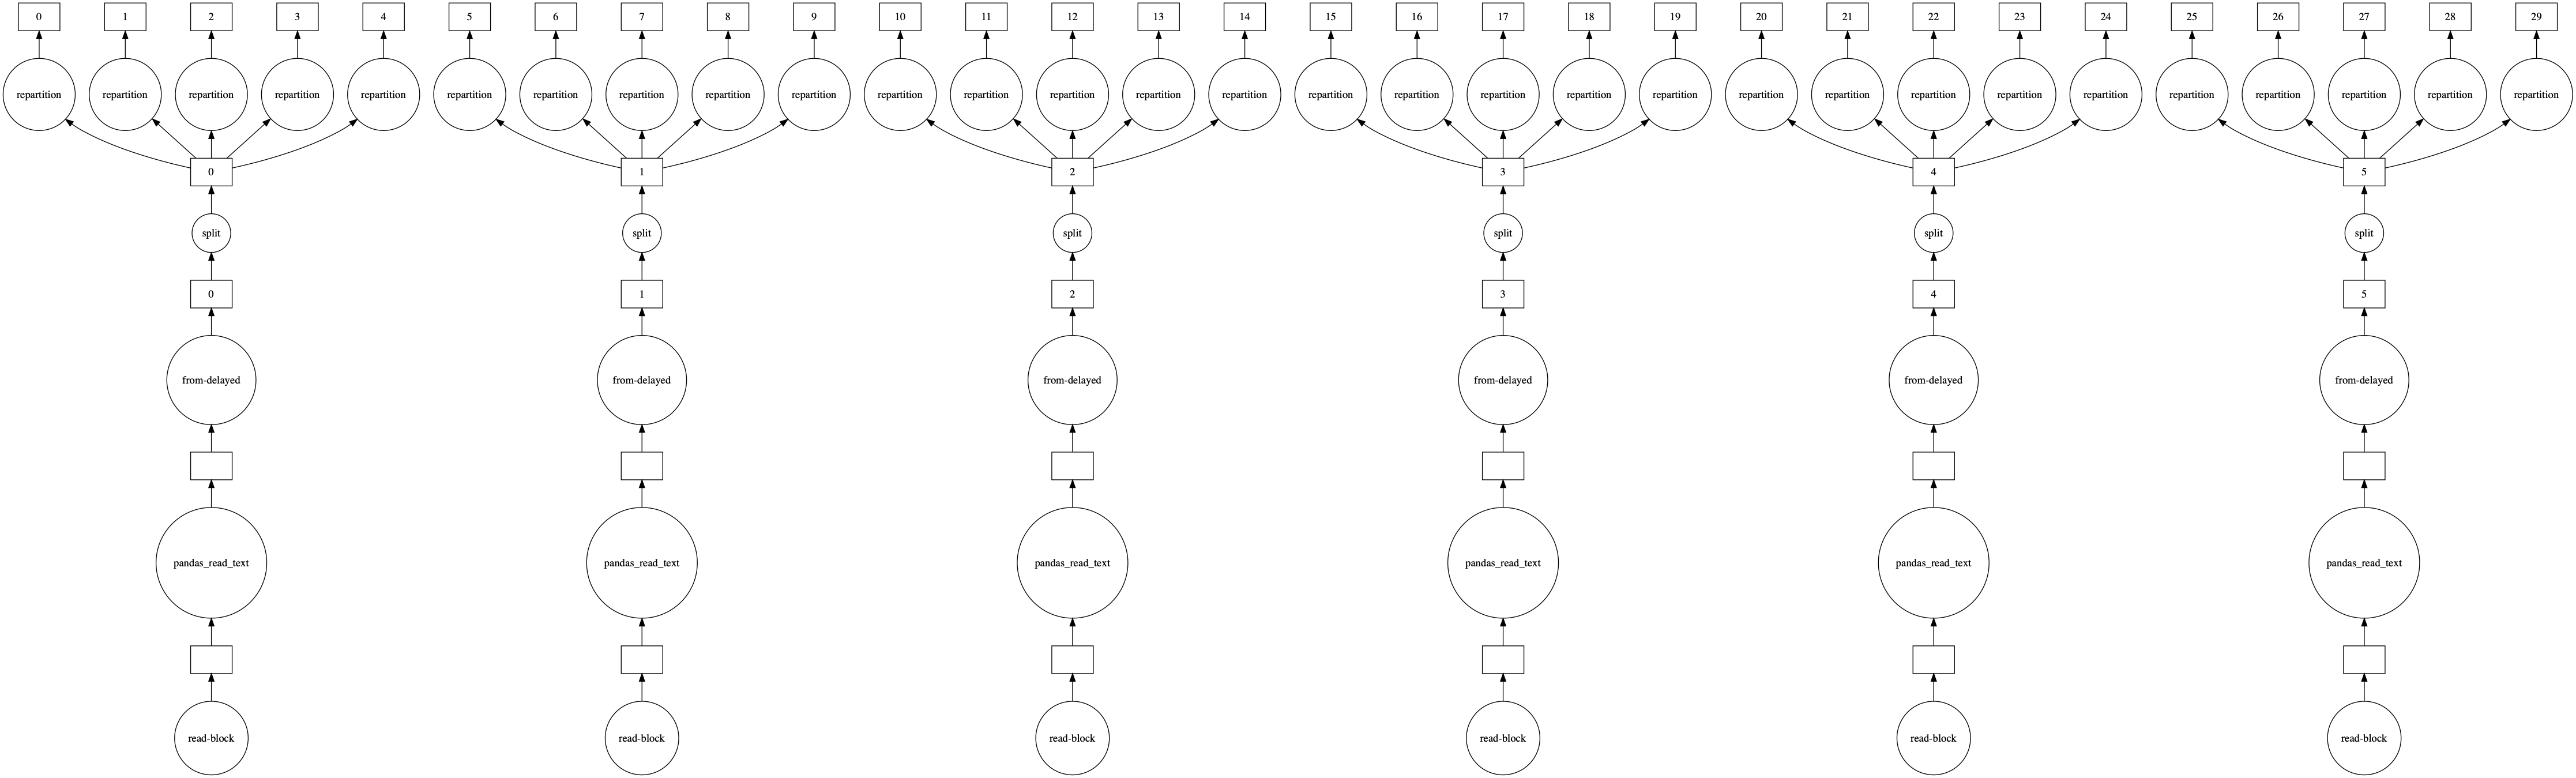

In [14]:
note_df.visualize()

In [15]:
note_df.columns

Index(['noteid', 'patientunitstayid', 'noteoffset', 'noteenteredoffset',
       'notetype', 'notepath', 'notevalue', 'notetext'],
      dtype='object')

In [16]:
note_df.dtypes

noteid                int64
patientunitstayid     int64
noteoffset            int64
noteenteredoffset     int64
notetype             object
notepath             object
notevalue            object
notetext             object
dtype: object

### Check for missing values

In [17]:
utils.dataframe_missing_values(note_df)

,column_name,percent_missing
noteid,noteid,0.000000
patientunitstayid,patientunitstayid,0.000000
noteoffset,noteoffset,0.000000
noteenteredoffset,noteenteredoffset,0.000000
notetype,notetype,0.000000
notepath,notepath,0.000000
notevalue,notevalue,0.000000
notetext,notetext,0.601727


### Remove unneeded features

In [18]:
note_df.notetype.value_counts().head(20)

Admission                       1182440
Comprehensive Progress           490955
Brief Progress                   263023
Re-Admission                      79013
Daily Progress                    55545
Central Venous Catheter           50346
Arterial Catheter                 26468
Intubation                        26067
Extubation                        19685
Follow-up Consultation/Other      18427
Initial Consultation/Other        11804
Dialysis Catheter                  7894
Bronchoscopy                       6966
Generic                            3830
Thoracentesis                      3282
Lumbar Puncture                    2556
Paracentesis                       2354
CPR                                1840
Cardioversion                       722
Pulmonary Artery Catheter           618
Name: notetype, dtype: int64

In [19]:
note_df.notepath.value_counts().head(40)

notes/Shared/View and Save/Save Options/Print/Copies/Copies                                                                                                   479129
notes/Progress Notes/Assessment and Plan/View Options/System View                                                                                             274138
notes/Progress Notes/Assessment and Plan/Include Rx/Include Rx                                                                                                170556
notes/Progress Notes/Admission Page One/Source of Patient Information:/Medical Records                                                                        128637
notes/Progress Notes/Allergies / Preadmission Medications/Allergies/Yes                                                                                       110190
notes/Progress Notes/Allergies / Preadmission Medications/Allergies/No                                                                                        108914
notes/Prog

In [20]:
note_df.notevalue.value_counts().head(20)

Copies                                                         479129
System View                                                    274138
Yes                                                            238677
Include Rx                                                     170556
No                                                             147682
Medical Records                                                128637
Unknown                                                        103129
Performed                                                       81556
Include Allergies and Pre-Admission Meds                        46564
Not Performed                                                   35062
Problem View                                                    34046
Include Social History and Family History                       27198
none                                                            23355
Communication with other healthcare providers and/or family     21859
Not Significant     

In [21]:
note_df[note_df.notepath.str.contains('notes/Progress Notes/Social History')].head(20)

,noteid,patientunitstayid,noteoffset,noteenteredoffset,notetype,notepath,notevalue,notetext
32647,4329987,258060,48,161,Admission,notes/Progress Notes/Social History / Family H...,Performed,Performed
32648,4329988,258060,48,161,Admission,notes/Progress Notes/Social History / Family H...,Not Significant,NotSignificant
33325,4372777,274270,74,84,Admission,notes/Progress Notes/Social History / Family H...,Performed,Performed
33326,4372778,274270,74,84,Admission,notes/Progress Notes/Social History / Family H...,Not Significant,NotSignificant
33484,4378389,285934,74,85,Admission,notes/Progress Notes/Social History / Family H...,Performed,Performed
33485,4378390,285934,74,85,Admission,notes/Progress Notes/Social History / Family H...,Not Performed,NotPerformed
33493,4378533,304291,238,261,Admission,notes/Progress Notes/Social History / Family H...,Performed,Performed
33494,4378534,304291,238,261,Admission,notes/Progress Notes/Social History / Family H...,Not Significant,NotSignificant
33561,4381999,257536,5,14,Re-Admission,notes/Progress Notes/Social History / Family H...,Performed,Performed
33562,4382000,257536,5,14,Re-Admission,notes/Progress Notes/Social History / Family H...,Not Significant,NotSignificant


In [22]:
note_df[note_df.notepath.str.contains('notes/Progress Notes/Social History')].notepath.value_counts().head(20)

notes/Progress Notes/Social History / Family History/Social History/Social History Obtain Options/Performed                                    59331
notes/Progress Notes/Social History / Family History/Social History/Social History/Ethanol Use/none                                            23355
notes/Progress Notes/Social History / Family History/Family History/Family History Obtain Options/Not Significant                              20817
notes/Progress Notes/Social History / Family History/Family History/Family History Obtain Options/Not Performed                                17370
notes/Progress Notes/Social History / Family History/Social History/Social History/Smoking Status/denies smoking                               16657
notes/Progress Notes/Social History / Family History/Family History/Family History Obtain Options/Unknown                                      14654
notes/Progress Notes/Social History / Family History/Family History/Family History Obtain Options/Performe

In [23]:
note_df[note_df.notepath.str.contains('notes/Progress Notes/Social History')].notevalue.value_counts().head(20)

Performed                                    71359
none                                         23355
Not Performed                                22908
Not Significant                              20817
denies smoking                               16657
Unknown                                      14654
CAD                                           5520
20 - 40 pack years - remote hx of smoking     5289
20 - 40 pack years - still smoking            4307
rare                                          4112
smoking history unknown                       4005
Cancer                                        3769
< 20 pack years - remote hx of smoking        3573
unknown                                       3540
moderate (not daily)                          3235
> 40 pack years - still smoking               2335
< 20 pack years - still smoking               2063
heavy                                         1930
moderate (daily)                              1870
> 40 pack years - remote hx of 

Out of all the possible notes, only those addressing the patient's social history seem to be interesting and containing information not found in other tables. As scuh, we'll only keep the note paths that mention social history:

In [24]:
note_df = note_df[note_df.notepath.str.contains('notes/Progress Notes/Social History')]
note_df.head()

,noteid,patientunitstayid,noteoffset,noteenteredoffset,notetype,notepath,notevalue,notetext
32647,4329987,258060,48,161,Admission,notes/Progress Notes/Social History / Family H...,Performed,Performed
32648,4329988,258060,48,161,Admission,notes/Progress Notes/Social History / Family H...,Not Significant,NotSignificant
33325,4372777,274270,74,84,Admission,notes/Progress Notes/Social History / Family H...,Performed,Performed
33326,4372778,274270,74,84,Admission,notes/Progress Notes/Social History / Family H...,Not Significant,NotSignificant
33484,4378389,285934,74,85,Admission,notes/Progress Notes/Social History / Family H...,Performed,Performed


In [25]:
len(note_df)

218329

There are still rows that seem to contain irrelevant data. Let's remove them by finding rows that contain specific words, like "obtain" and "print", that only appear in said irrelevant rows:

In [26]:
category_types_to_remove = ['obtain', 'print', 'copies', 'options']

In [27]:
utils.find_row_contains_word(note_df, feature='notepath', words=category_types_to_remove).value_counts().compute()

True     129738
False     88591
Name: row, dtype: int64

In [28]:
note_df = note_df[~utils.find_row_contains_word(note_df, feature='notepath', words=category_types_to_remove)]
note_df.head()

,noteid,patientunitstayid,noteoffset,noteenteredoffset,notetype,notepath,notevalue,notetext
38637,4696405,270717,28,42,Admission,notes/Progress Notes/Social History / Family H...,20 - 40 pack years - still smoking,20 - 40 pack years - still smoking
38638,4696406,270717,28,42,Admission,notes/Progress Notes/Social History / Family H...,heavy,heavy
38639,4696408,270717,28,42,Admission,notes/Progress Notes/Social History / Family H...,CAD,CAD
38640,4696409,270717,28,42,Admission,notes/Progress Notes/Social History / Family H...,Cancer,Cancer
43007,4984622,264276,17,53,Admission,notes/Progress Notes/Social History / Family H...,20 - 40 pack years - still smoking,20 - 40 pack years - still smoking


In [29]:
len(note_df)

88591

In [30]:
note_df.patientunitstayid.nunique().compute()

41070

In [31]:
note_df.notetype.value_counts().head(20)

Admission                     81878
Re-Admission                   5691
Initial Consultation/Other     1022
Name: notetype, dtype: int64

Filtering just for interesting social history data greatly reduced the data volume of the notes table, now only present in around 20.5% of the unit stays. Still, it might be useful to include.

Besides the usual removal of row identifier, `noteid`, I'm also removing apparently irrelevant (`noteenteredoffset`, `notetype`) and redundant (`notetext`) columns:

In [32]:
note_df = note_df.drop(['noteid', 'noteenteredoffset', 'notetype', 'notetext'], axis=1)
note_df.head()

,patientunitstayid,noteoffset,notepath,notevalue
38637,270717,28,notes/Progress Notes/Social History / Family H...,20 - 40 pack years - still smoking
38638,270717,28,notes/Progress Notes/Social History / Family H...,heavy
38639,270717,28,notes/Progress Notes/Social History / Family H...,CAD
38640,270717,28,notes/Progress Notes/Social History / Family H...,Cancer
43007,264276,17,notes/Progress Notes/Social History / Family H...,20 - 40 pack years - still smoking


### Separate high level notes

In [33]:
note_df.notepath.value_counts().head(20)

notes/Progress Notes/Social History / Family History/Social History/Social History/Ethanol Use/none                                            23355
notes/Progress Notes/Social History / Family History/Social History/Social History/Smoking Status/denies smoking                               16657
notes/Progress Notes/Social History / Family History/Family History/Family History/CAD/CAD                                                      5520
notes/Progress Notes/Social History / Family History/Social History/Social History/Smoking Status/20 - 40 pack years - remote hx of smoking     5289
notes/Progress Notes/Social History / Family History/Social History/Social History/Smoking Status/20 - 40 pack years - still smoking            4307
notes/Progress Notes/Social History / Family History/Social History/Social History/Ethanol Use/rare                                             4112
notes/Progress Notes/Social History / Family History/Social History/Social History/Smoking Status/smoking 

In [34]:
note_df.notepath.map(lambda x: x.split('/')).head().values

array([list(['notes', 'Progress Notes', 'Social History ', ' Family History', 'Social History', 'Social History', 'Smoking Status', '20 - 40 pack years - still smoking']),
       list(['notes', 'Progress Notes', 'Social History ', ' Family History', 'Social History', 'Social History', 'Ethanol Use', 'heavy']),
       list(['notes', 'Progress Notes', 'Social History ', ' Family History', 'Family History', 'Family History', 'CAD', 'CAD']),
       list(['notes', 'Progress Notes', 'Social History ', ' Family History', 'Family History', 'Family History', 'Cancer', 'Cancer']),
       list(['notes', 'Progress Notes', 'Social History ', ' Family History', 'Social History', 'Social History', 'Smoking Status', '20 - 40 pack years - still smoking'])],
      dtype=object)

In [35]:
note_df.notepath.map(lambda x: len(x.split('/'))).min().compute()

8.0

In [36]:
note_df.notepath.map(lambda x: len(x.split('/'))).max().compute()

8.0

In [37]:
note_df.notepath.apply(lambda x: utils.get_element_from_split(x, 1, separator='/'),
                       meta=('x', str)).value_counts().compute()

Progress Notes    88591
Name: x, dtype: int64

In [38]:
note_df.notepath.apply(lambda x: utils.get_element_from_split(x, 2, separator='/'),
                       meta=('x', str)).value_counts().compute()

Social History     88591
Name: x, dtype: int64

In [39]:
note_df.notepath.apply(lambda x: utils.get_element_from_split(x, 3, separator='/'),
                       meta=('x', str)).value_counts().compute()

 Family History    88591
Name: x, dtype: int64

In [40]:
note_df.notepath.apply(lambda x: utils.get_element_from_split(x, 4, separator='/'),
                       meta=('x', str)).value_counts().compute()

Social History    79251
Family History     9340
Name: x, dtype: int64

In [41]:
note_df.notepath.apply(lambda x: utils.get_element_from_split(x, 5, separator='/'),
                       meta=('x', str)).value_counts().compute()

Social History    79251
Family History     9340
Name: x, dtype: int64

In [42]:
note_df.notepath.apply(lambda x: utils.get_element_from_split(x, 6, separator='/'),
                       meta=('x', str)).value_counts().compute()

Smoking Status        40809
Ethanol Use           38339
CAD                    5520
Cancer                 3769
Recent Travel           103
Bleeding Disorders       51
Name: x, dtype: int64

In [43]:
note_df.notepath.apply(lambda x: utils.get_element_from_split(x, 7, separator='/'),
                       meta=('x', str)).value_counts().compute()

none                                           23355
denies smoking                                 16657
CAD                                             5520
20 - 40 pack years - remote hx of smoking       5289
20 - 40 pack years - still smoking              4307
rare                                            4112
smoking history unknown                         4005
Cancer                                          3769
< 20 pack years - remote hx of smoking          3573
unknown                                         3540
moderate (not daily)                            3235
> 40 pack years - still smoking                 2335
< 20 pack years - still smoking                 2063
heavy                                           1930
moderate (daily)                                1870
> 40 pack years - remote hx of smoking          1792
smoker, duration unknown                         511
uses smokeless tobacco                           164
hx withdrawal seizures                        

In [44]:
note_df.notevalue.value_counts().compute()

none                                           23355
denies smoking                                 16657
CAD                                             5520
20 - 40 pack years - remote hx of smoking       5289
20 - 40 pack years - still smoking              4307
rare                                            4112
smoking history unknown                         4005
Cancer                                          3769
< 20 pack years - remote hx of smoking          3573
unknown                                         3540
moderate (not daily)                            3235
> 40 pack years - still smoking                 2335
< 20 pack years - still smoking                 2063
heavy                                           1930
moderate (daily)                                1870
> 40 pack years - remote hx of smoking          1792
smoker, duration unknown                         511
uses smokeless tobacco                           164
hx withdrawal seizures                        

There are always 8 levels of the notes. As the first 6 ones are essentially always the same ("notes/Progress Notes/Social History / Family History/Social History/Social History/"), it's best to just preserve the 7th one and isolate the 8th in a new feature. This way, the split provides further insight to the model on similar notes. However, it's also worth taking note that the 8th level of `notepath` seems to be identical to the feature `notevalue`. We'll look more into it later.

In [45]:
note_df['notetopic'] = note_df.notepath.apply(lambda x: utils.get_element_from_split(x, 6, separator='/'), meta=('x', str))
note_df['notedetails'] = note_df.notepath.apply(lambda x: utils.get_element_from_split(x, 7, separator='/'), meta=('x', str))
note_df.head()

,patientunitstayid,noteoffset,notepath,notevalue,notetopic,notedetails
38637,270717,28,notes/Progress Notes/Social History / Family H...,20 - 40 pack years - still smoking,Smoking Status,20 - 40 pack years - still smoking
38638,270717,28,notes/Progress Notes/Social History / Family H...,heavy,Ethanol Use,heavy
38639,270717,28,notes/Progress Notes/Social History / Family H...,CAD,CAD,CAD
38640,270717,28,notes/Progress Notes/Social History / Family H...,Cancer,Cancer,Cancer
43007,264276,17,notes/Progress Notes/Social History / Family H...,20 - 40 pack years - still smoking,Smoking Status,20 - 40 pack years - still smoking


In [46]:
note_df[note_df.notevalue != note_df.notedetails].compute()

,patientunitstayid,noteoffset,notepath,notevalue,notetopic,notedetails


The previous blank output confirms that the newly created `notedetails` feature is exactly equal to the already existing `notevalue` feature. So, we should remove one of them:

In [47]:
note_df = note_df.drop('notedetails', axis=1)
note_df.head()

,patientunitstayid,noteoffset,notepath,notevalue,notetopic
38637,270717,28,notes/Progress Notes/Social History / Family H...,20 - 40 pack years - still smoking,Smoking Status
38638,270717,28,notes/Progress Notes/Social History / Family H...,heavy,Ethanol Use
38639,270717,28,notes/Progress Notes/Social History / Family H...,CAD,CAD
38640,270717,28,notes/Progress Notes/Social History / Family H...,Cancer,Cancer
43007,264276,17,notes/Progress Notes/Social History / Family H...,20 - 40 pack years - still smoking,Smoking Status


In [48]:
note_df[note_df.notetopic == 'Smoking Status'].notevalue.value_counts().compute()

denies smoking                               16657
20 - 40 pack years - remote hx of smoking     5289
20 - 40 pack years - still smoking            4307
smoking history unknown                       4005
< 20 pack years - remote hx of smoking        3573
> 40 pack years - still smoking               2335
< 20 pack years - still smoking               2063
> 40 pack years - remote hx of smoking        1792
smoker, duration unknown                       511
uses smokeless tobacco                         164
smokes cigar or pipe                           113
Name: notevalue, dtype: int64

In [49]:
note_df[note_df.notetopic == 'Ethanol Use'].notevalue.value_counts().compute()

none                                           23355
rare                                            4112
unknown                                         3540
moderate (not daily)                            3235
heavy                                           1930
moderate (daily)                                1870
hx withdrawal seizures                           152
hx delirium tremens                              101
hx delirium tremens and withdrawal seizures       44
Name: notevalue, dtype: int64

In [50]:
note_df[note_df.notetopic == 'CAD'].notevalue.value_counts().compute()

CAD    5520
Name: notevalue, dtype: int64

In [51]:
note_df[note_df.notetopic == 'Cancer'].notevalue.value_counts().compute()

Cancer    3769
Name: notevalue, dtype: int64

In [52]:
note_df[note_df.notetopic == 'Recent Travel'].notevalue.value_counts().compute()

recent travel    103
Name: notevalue, dtype: int64

In [53]:
note_df[note_df.notetopic == 'Bleeding Disorders'].notevalue.value_counts().compute()

Bleeding Disorder    51
Name: notevalue, dtype: int64

Considering how only the categories of "Smoking Status" and "Ethanol Use" in `notetopic` have more than one possible `notevalue` category, with the remaining being only 2 useful ones (categories "Recent Travel" and "Bleeding Disorders" have too little samples), it's probably best to just turn them into features, instead of packing in the same embedded feature.

### Convert categories to features

In [ ]:
note_df.reset_index().head()

Make the `notetopic` and `notevalue` columns of type categorical:

In [ ]:
note_df = note_df.categorize(columns=['notetopic', 'notevalue'])

Transform the `notetopic` categories and `notevalue` values into separate features:

In [ ]:
note_df.reset_index().pivot_table(index='index', columns='notetopic', values='notevalue', aggfunc='sum').head()

In [64]:
def category_to_feature(df, categories_feature, values_feature):
    # Copy the dataframe to avoid potentially unwanted inplace changes
    data_df = df.copy()
    # Find the unique categories
    categories = data_df[categories_feature].unique()
    if 'dask' in str(type(df)):
        categories = categories.compute()
    # Create a feature for each category
    for category in categories:
        data_df[category] = data_df.apply(lambda x: x[values_feature] if x[categories_feature] == category
                                                     else np.nan, axis=1)
    return data_df

In [65]:
category_to_feature(note_df, categories_feature='notetopic', values_feature='notevalue').head()

/Users/andreferreira/Library/Caches/pypoetry/virtualenvs/eicu-mortality-prediction-py3.7/lib/python3.7/site-packages/dask/dataframe/core.py:3968: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'float64'))

  warnings.warn(meta_warning(meta))


,patientunitstayid,noteoffset,notepath,notevalue,notetopic,Smoking Status,Ethanol Use,CAD,Cancer,Bleeding Disorders,Recent Travel
38637,270717,28,notes/Progress Notes/Social History / Family H...,20 - 40 pack years - still smoking,Smoking Status,NaN,NaN,NaN,NaN,NaN,NaN
38638,270717,28,notes/Progress Notes/Social History / Family H...,heavy,Ethanol Use,NaN,NaN,NaN,NaN,NaN,NaN
38639,270717,28,notes/Progress Notes/Social History / Family H...,CAD,CAD,NaN,NaN,NaN,NaN,NaN,NaN
38640,270717,28,notes/Progress Notes/Social History / Family H...,Cancer,Cancer,NaN,NaN,NaN,NaN,NaN,NaN
43007,264276,17,notes/Progress Notes/Social History / Family H...,20 - 40 pack years - still smoking,Smoking Status,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
note_df[note_df.notetopic == 'Smoking Status'].head()

,patientunitstayid,noteoffset,notepath,notevalue,notetopic
38637,270717,28,notes/Progress Notes/Social History / Family H...,20 - 40 pack years - still smoking,Smoking Status
43007,264276,17,notes/Progress Notes/Social History / Family H...,20 - 40 pack years - still smoking,Smoking Status
47397,280541,7,notes/Progress Notes/Social History / Family H...,< 20 pack years - still smoking,Smoking Status
53915,271914,97,notes/Progress Notes/Social History / Family H...,denies smoking,Smoking Status
56389,308810,37,notes/Progress Notes/Social History / Family H...,< 20 pack years - remote hx of smoking,Smoking Status


In [60]:
tmp_df = note_df.copy()

In [61]:
category = 'Smoking Status'
categories_feature = 'notetopic'
values_feature = 'notevalue'

In [62]:
tmp_df[category] = tmp_df.apply(lambda df: df[values_feature] if df[categories_feature] == category
                                                     else np.nan, axis=1)
tmp_df.head()

,patientunitstayid,noteoffset,notepath,notevalue,notetopic,Smoking Status
38637,270717,28,notes/Progress Notes/Social History / Family H...,20 - 40 pack years - still smoking,Smoking Status,20 - 40 pack years - still smoking
38638,270717,28,notes/Progress Notes/Social History / Family H...,heavy,Ethanol Use,NaN
38639,270717,28,notes/Progress Notes/Social History / Family H...,CAD,CAD,NaN
38640,270717,28,notes/Progress Notes/Social History / Family H...,Cancer,Cancer,NaN
43007,264276,17,notes/Progress Notes/Social History / Family H...,20 - 40 pack years - still smoking,Smoking Status,20 - 40 pack years - still smoking


In [109]:
# Copy the dataframe to avoid potentially unwanted inplace changes
data_df = note_df.copy()

In [110]:
# Find the unique categories
categories = data_df[categories_feature].unique()
if 'dask' in str(type(data_df)):
    categories = categories.compute()
categories

0        Smoking Status
1           Ethanol Use
2                   CAD
3                Cancer
4    Bleeding Disorders
5         Recent Travel
Name: notetopic, dtype: object

In [111]:
from IPython.display import display

In [112]:
# Create a feature for each category
series_list = []
for category in categories:
#     data_df[category] = data_df.apply(lambda x: x[values_feature] if x[categories_feature] == category
#                                                  else np.nan, axis=1)
#     display(category)
#     display(data_df.head())
    data_df = data_df.copy()
    series_list.append(data_df.apply(lambda x: x[values_feature] if x[categories_feature] == category
                                                 else np.nan, axis=1))
    [display(series.head()) for series in series_list]
for idx in range(len(categories)):
    data_df[categories[idx]] = series_list[idx]
    display(categories[idx])
    display(data_df.head())
data_df.head()

/Users/andreferreira/Library/Caches/pypoetry/virtualenvs/eicu-mortality-prediction-py3.7/lib/python3.7/site-packages/dask/dataframe/core.py:3968: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'float64'))

  warnings.warn(meta_warning(meta))


38637    20 - 40 pack years - still smoking
38638                                   NaN
38639                                   NaN
38640                                   NaN
43007    20 - 40 pack years - still smoking
dtype: object

/Users/andreferreira/Library/Caches/pypoetry/virtualenvs/eicu-mortality-prediction-py3.7/lib/python3.7/site-packages/dask/dataframe/core.py:3968: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'float64'))

  warnings.warn(meta_warning(meta))


38637      NaN
38638    heavy
38639      NaN
38640      NaN
43007      NaN
dtype: object

38637      NaN
38638    heavy
38639      NaN
38640      NaN
43007      NaN
dtype: object

/Users/andreferreira/Library/Caches/pypoetry/virtualenvs/eicu-mortality-prediction-py3.7/lib/python3.7/site-packages/dask/dataframe/core.py:3968: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'float64'))

  warnings.warn(meta_warning(meta))


38637    NaN
38638    NaN
38639    CAD
38640    NaN
43007    NaN
dtype: object

38637    NaN
38638    NaN
38639    CAD
38640    NaN
43007    NaN
dtype: object

38637    NaN
38638    NaN
38639    CAD
38640    NaN
43007    NaN
dtype: object

/Users/andreferreira/Library/Caches/pypoetry/virtualenvs/eicu-mortality-prediction-py3.7/lib/python3.7/site-packages/dask/dataframe/core.py:3968: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'float64'))

  warnings.warn(meta_warning(meta))


38637       NaN
38638       NaN
38639       NaN
38640    Cancer
43007       NaN
dtype: object

38637       NaN
38638       NaN
38639       NaN
38640    Cancer
43007       NaN
dtype: object

38637       NaN
38638       NaN
38639       NaN
38640    Cancer
43007       NaN
dtype: object

38637       NaN
38638       NaN
38639       NaN
38640    Cancer
43007       NaN
dtype: object

/Users/andreferreira/Library/Caches/pypoetry/virtualenvs/eicu-mortality-prediction-py3.7/lib/python3.7/site-packages/dask/dataframe/core.py:3968: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'float64'))

  warnings.warn(meta_warning(meta))


38637    NaN
38638    NaN
38639    NaN
38640    NaN
43007    NaN
dtype: object

38637    NaN
38638    NaN
38639    NaN
38640    NaN
43007    NaN
dtype: object

38637    NaN
38638    NaN
38639    NaN
38640    NaN
43007    NaN
dtype: object

38637    NaN
38638    NaN
38639    NaN
38640    NaN
43007    NaN
dtype: object

38637    NaN
38638    NaN
38639    NaN
38640    NaN
43007    NaN
dtype: object

/Users/andreferreira/Library/Caches/pypoetry/virtualenvs/eicu-mortality-prediction-py3.7/lib/python3.7/site-packages/dask/dataframe/core.py:3968: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'float64'))

  warnings.warn(meta_warning(meta))


38637   NaN
38638   NaN
38639   NaN
38640   NaN
43007   NaN
dtype: float64

38637   NaN
38638   NaN
38639   NaN
38640   NaN
43007   NaN
dtype: float64

38637   NaN
38638   NaN
38639   NaN
38640   NaN
43007   NaN
dtype: float64

38637   NaN
38638   NaN
38639   NaN
38640   NaN
43007   NaN
dtype: float64

38637   NaN
38638   NaN
38639   NaN
38640   NaN
43007   NaN
dtype: float64

38637   NaN
38638   NaN
38639   NaN
38640   NaN
43007   NaN
dtype: float64

'Smoking Status'

,patientunitstayid,noteoffset,notepath,notevalue,notetopic,Smoking Status
38637,270717,28,notes/Progress Notes/Social History / Family H...,20 - 40 pack years - still smoking,Smoking Status,NaN
38638,270717,28,notes/Progress Notes/Social History / Family H...,heavy,Ethanol Use,NaN
38639,270717,28,notes/Progress Notes/Social History / Family H...,CAD,CAD,NaN
38640,270717,28,notes/Progress Notes/Social History / Family H...,Cancer,Cancer,NaN
43007,264276,17,notes/Progress Notes/Social History / Family H...,20 - 40 pack years - still smoking,Smoking Status,NaN


'Ethanol Use'

,patientunitstayid,noteoffset,notepath,notevalue,notetopic,Smoking Status,Ethanol Use
38637,270717,28,notes/Progress Notes/Social History / Family H...,20 - 40 pack years - still smoking,Smoking Status,NaN,NaN
38638,270717,28,notes/Progress Notes/Social History / Family H...,heavy,Ethanol Use,NaN,NaN
38639,270717,28,notes/Progress Notes/Social History / Family H...,CAD,CAD,NaN,NaN
38640,270717,28,notes/Progress Notes/Social History / Family H...,Cancer,Cancer,NaN,NaN
43007,264276,17,notes/Progress Notes/Social History / Family H...,20 - 40 pack years - still smoking,Smoking Status,NaN,NaN


'CAD'

,patientunitstayid,noteoffset,notepath,notevalue,notetopic,Smoking Status,Ethanol Use,CAD
38637,270717,28,notes/Progress Notes/Social History / Family H...,20 - 40 pack years - still smoking,Smoking Status,NaN,NaN,NaN
38638,270717,28,notes/Progress Notes/Social History / Family H...,heavy,Ethanol Use,NaN,NaN,NaN
38639,270717,28,notes/Progress Notes/Social History / Family H...,CAD,CAD,NaN,NaN,NaN
38640,270717,28,notes/Progress Notes/Social History / Family H...,Cancer,Cancer,NaN,NaN,NaN
43007,264276,17,notes/Progress Notes/Social History / Family H...,20 - 40 pack years - still smoking,Smoking Status,NaN,NaN,NaN


'Cancer'

,patientunitstayid,noteoffset,notepath,notevalue,notetopic,Smoking Status,Ethanol Use,CAD,Cancer
38637,270717,28,notes/Progress Notes/Social History / Family H...,20 - 40 pack years - still smoking,Smoking Status,NaN,NaN,NaN,NaN
38638,270717,28,notes/Progress Notes/Social History / Family H...,heavy,Ethanol Use,NaN,NaN,NaN,NaN
38639,270717,28,notes/Progress Notes/Social History / Family H...,CAD,CAD,NaN,NaN,NaN,NaN
38640,270717,28,notes/Progress Notes/Social History / Family H...,Cancer,Cancer,NaN,NaN,NaN,NaN
43007,264276,17,notes/Progress Notes/Social History / Family H...,20 - 40 pack years - still smoking,Smoking Status,NaN,NaN,NaN,NaN


'Bleeding Disorders'

,patientunitstayid,noteoffset,notepath,notevalue,notetopic,Smoking Status,Ethanol Use,CAD,Cancer,Bleeding Disorders
38637,270717,28,notes/Progress Notes/Social History / Family H...,20 - 40 pack years - still smoking,Smoking Status,NaN,NaN,NaN,NaN,NaN
38638,270717,28,notes/Progress Notes/Social History / Family H...,heavy,Ethanol Use,NaN,NaN,NaN,NaN,NaN
38639,270717,28,notes/Progress Notes/Social History / Family H...,CAD,CAD,NaN,NaN,NaN,NaN,NaN
38640,270717,28,notes/Progress Notes/Social History / Family H...,Cancer,Cancer,NaN,NaN,NaN,NaN,NaN
43007,264276,17,notes/Progress Notes/Social History / Family H...,20 - 40 pack years - still smoking,Smoking Status,NaN,NaN,NaN,NaN,NaN


'Recent Travel'

,patientunitstayid,noteoffset,notepath,notevalue,notetopic,Smoking Status,Ethanol Use,CAD,Cancer,Bleeding Disorders,Recent Travel
38637,270717,28,notes/Progress Notes/Social History / Family H...,20 - 40 pack years - still smoking,Smoking Status,NaN,NaN,NaN,NaN,NaN,NaN
38638,270717,28,notes/Progress Notes/Social History / Family H...,heavy,Ethanol Use,NaN,NaN,NaN,NaN,NaN,NaN
38639,270717,28,notes/Progress Notes/Social History / Family H...,CAD,CAD,NaN,NaN,NaN,NaN,NaN,NaN
38640,270717,28,notes/Progress Notes/Social History / Family H...,Cancer,Cancer,NaN,NaN,NaN,NaN,NaN,NaN
43007,264276,17,notes/Progress Notes/Social History / Family H...,20 - 40 pack years - still smoking,Smoking Status,NaN,NaN,NaN,NaN,NaN,NaN


,patientunitstayid,noteoffset,notepath,notevalue,notetopic,Smoking Status,Ethanol Use,CAD,Cancer,Bleeding Disorders,Recent Travel
38637,270717,28,notes/Progress Notes/Social History / Family H...,20 - 40 pack years - still smoking,Smoking Status,NaN,NaN,NaN,NaN,NaN,NaN
38638,270717,28,notes/Progress Notes/Social History / Family H...,heavy,Ethanol Use,NaN,NaN,NaN,NaN,NaN,NaN
38639,270717,28,notes/Progress Notes/Social History / Family H...,CAD,CAD,NaN,NaN,NaN,NaN,NaN,NaN
38640,270717,28,notes/Progress Notes/Social History / Family H...,Cancer,Cancer,NaN,NaN,NaN,NaN,NaN,NaN
43007,264276,17,notes/Progress Notes/Social History / Family H...,20 - 40 pack years - still smoking,Smoking Status,NaN,NaN,NaN,NaN,NaN,NaN


In [100]:
list(range(len(categories)))

[0, 1, 2, 3, 4, 5]

In [87]:
data_df[categories[0]]

KeyError: 'Smoking Status'

### Discretize categorical features

Convert binary categorical features into simple numberings, one hot encode features with a low number of categories (in this case, 5) and enumerate sparse categorical features that will be embedded.

#### Separate and prepare features for embedding

Identify categorical features that have more than 5 unique categories, which will go through an embedding layer afterwards, and enumerate them.

Update list of categorical features and add those that will need embedding (features with more than 5 unique values):

In [ ]:
new_cat_feat = ['diagnosis_type_1', 'diagnosis_disorder_2', 'diagnosis_detailed_3']
[cat_feat.append(col) for col in new_cat_feat]

In [ ]:
cat_feat_nunique = [diagn_df[feature].nunique().compute() for feature in new_cat_feat]
cat_feat_nunique

In [ ]:
new_cat_embed_feat = []
for i in range(len(new_cat_feat)):
    if cat_feat_nunique[i] > 5:
        # Add feature to the list of those that will be embedded
        cat_embed_feat.append(new_cat_feat[i])
        new_cat_embed_feat.append(new_cat_feat[i])

In [ ]:
diagn_df[new_cat_feat].head()

In [ ]:
for i in range(len(new_cat_embed_feat)):
    feature = new_cat_embed_feat[i]
    # Prepare for embedding, i.e. enumerate categories
    diagn_df[feature], cat_embed_feat_enum[feature] = utils.enum_categorical_feature(diagn_df, feature)

In [ ]:
diagn_df[new_cat_feat].head()

In [ ]:
cat_embed_feat_enum

In [ ]:
diagn_df[new_cat_feat].dtypes

In [ ]:
diagn_df.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
diagn_df = client.persist(diagn_df)

In [ ]:
diagn_df.visualize()

### Create the timestamp feature and sort

Create the timestamp (`ts`) feature:

In [ ]:
diagn_df['ts'] = diagn_df['diagnosisoffset']
diagn_df = diagn_df.drop('diagnosisoffset', axis=1)
diagn_df.head()

Remove duplicate rows:

In [ ]:
len(diagn_df)

In [ ]:
diagn_df = diagn_df.drop_duplicates()
diagn_df.head()

In [ ]:
len(diagn_df)

In [ ]:
diagn_df = diagn_df.repartition(npartitions=30)

Sort by `ts` so as to be easier to merge with other dataframes later:

In [ ]:
diagn_df = diagn_df.set_index('ts')
diagn_df.head()

In [ ]:
diagn_df.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
diagn_df = client.persist(diagn_df)

In [ ]:
diagn_df.visualize()

Check for possible multiple rows with the same unit stay ID and timestamp:

In [ ]:
diagn_df.reset_index().head()

In [ ]:
diagn_df.reset_index().groupby(['patientunitstayid', 'ts']).count().nlargest(columns='diagnosis_type_1').head()

In [ ]:
diagn_df[diagn_df.patientunitstayid == 3089982].compute().head(10)

We can see that there are up to 69 categories per set of `patientunitstayid` and `ts`. As such, we must join them.

### Join rows that have the same IDs

In [ ]:
diagn_df = utils.join_categorical_enum(diagn_df, new_cat_embed_feat)
diagn_df.head()

In [ ]:
diagn_df.dtypes

In [ ]:
diagn_df.reset_index().groupby(['patientunitstayid', 'ts']).count().nlargest(columns='diagnosis_type_1').head()

In [ ]:
diagn_df[diagn_df.patientunitstayid == 3089982].compute().head(10)

Comparing the output from the two previous cells with what we had before the `join_categorical_enum` method, we can see that all rows with duplicate IDs have been successfully joined.

In [ ]:
diagn_df.visualize()

In [ ]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
diagn_df = client.persist(diagn_df)

In [ ]:
diagn_df.visualize()

### Save the dataframe

In [ ]:
diagn_df = diagn_df.repartition(npartitions=30)

In [ ]:
diagn_df.to_parquet(f'{data_path}cleaned/unnormalized/diagnosis.parquet')

In [ ]:
diagn_df.to_parquet(f'{data_path}cleaned/normalized/diagnosis.parquet')

Confirm that everything is ok through the `describe` method:

In [ ]:
diagn_df.describe().compute().transpose()

### Join dataframes

Merge dataframes by the unit stay, `patientunitstayid`, and the timestamp, `ts`, with a tolerence for a difference of up to 30 minutes.

In [ ]:
diagn_df = dd.read_parquet(f'{data_path}cleaned/normalized/diagnosis.parquet')
diagn_df.head()

In [ ]:
diagn_df.npartitions

In [ ]:
eICU_df = dd.merge_asof(eICU_df, diagn_df, on='ts', by='patientunitstayid', direction='nearest', tolerance=30)
eICU_df.head()